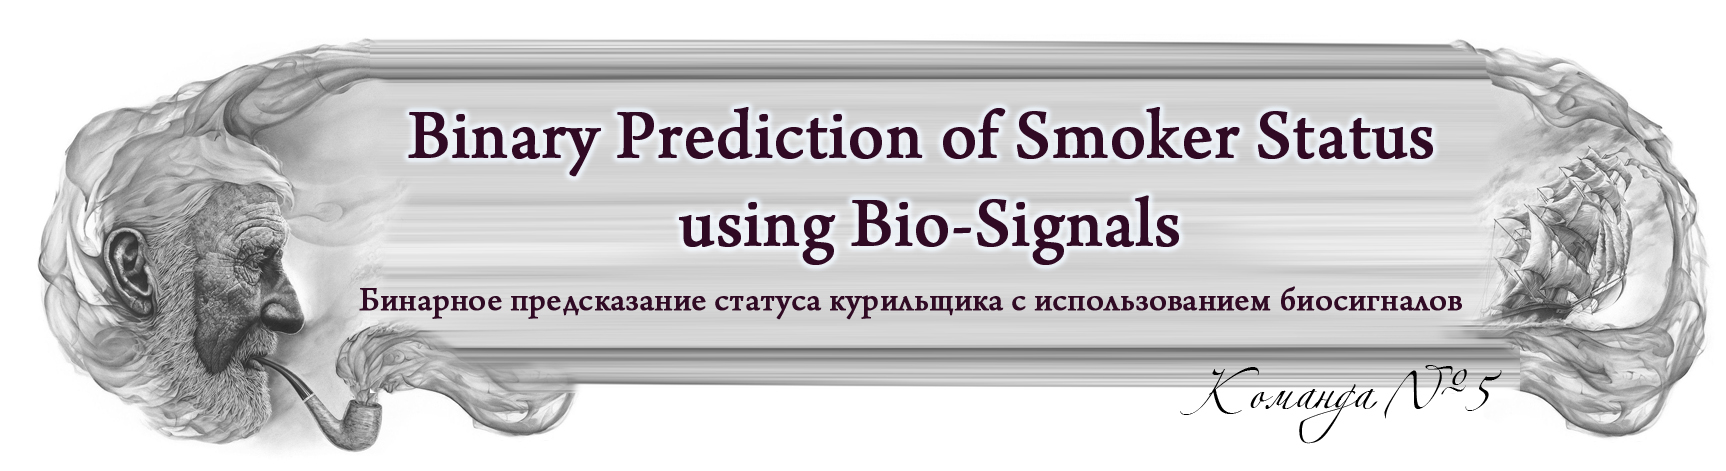

In [2]:
from IPython.display import Image
Image('binary_smoker.jpg')


**Это датасет по классификации пациентов на основе различных измерений (био-сигналов). Датасет размещен по ссылке:
https://www.kaggle.com/competitions/playground-series-s3e24/data**

С целями разработки проекта можно ознакомиться здесь (https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals), поскольку наш датасет был сформирован на основании вышеуказанного.

Так, составители датасета указали, что многие врачи прекратили консультирование пациентов по вопросу отказа от курения ввиду неэффективности. В частности, многие пациенты возвращались к вредной привычке, несмотря на врачебные предписания. Чтобы преодолеть эту проблему, было предложено обучить модель выявлять признаки, которые отличали бы курящих людей от некурящих, чтобы на основании этих признаков врачи имели возможность выявлять пациентов, которые имеют больше шансов бросить курить.

В датасете используются следующие признаки признаки: возраст, рост(см), вес(кг), талия(см), зрение(левый глаз и правый), слух (левое и право ухо), артериальное давление (верхнее систолическое и нижнее дистолическое), уровень сахара в крови натощак, холестерин (общий, а также LDL и HDL), триглицериды, гемоглобин, белок мочи, сывороточный креатинин, АСТ, АЛТ, ГТП(гамма-глутамилтранспептидаза), кариес зубов.

Целевой переменной является статус курения (0 - не курит, 1 - курит).


**В первую очередь обзорно исследуем датасет**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv("train.csv", index_col='id') # Импорт датасета для обучения, столбец 'id' взят как индекс строк

**Здесь же сразу отделим сырые данные для построения бэйзлайн модели**

In [9]:
raw_df = df.copy() # создание копии "сырого" датафрейма

In [11]:
raw_X_train = raw_df.drop(columns = ['smoking']) # разделение "сырого" датафрейма на признаки и таргетную переменную
raw_y_train = raw_df['smoking']

X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(raw_X_train, raw_y_train, test_size = 0.2, random_state = 42)

In [13]:
df_test = pd.read_csv("test.csv", index_col='id')
raw_df_test = df_test.copy() # создание копии "сырой" тестовой выборки

In [15]:
raw_model = LogisticRegression(solver='liblinear', random_state=42) # единые параметры для "сырых" и предобработанных данных 
                                                                    # для воспроизводимости результатов

In [17]:
raw_model.fit(X_raw_train, y_raw_train) # обучение модели
raw_y_train_pred = raw_model.predict(X_raw_test) # предсказание целевой переменной

**Метрики на сырую модель на тестовых данных**

In [19]:
raw_accuracy = accuracy_score(y_raw_test, raw_y_train_pred)
raw_precision = precision_score(y_raw_test, raw_y_train_pred)
raw_recall = recall_score(y_raw_test, raw_y_train_pred)
raw_f1 = f1_score(y_raw_test, raw_y_train_pred)
raw_roc_auc = roc_auc_score(y_raw_test, raw_model.predict_proba(X_raw_test)[:, 1])

print(f'Accuracy for raw DataFrame: {raw_accuracy}')
print(f'Precision for raw DataFrame: {raw_precision}')
print(f'Recall for raw DataFrame: {raw_recall}')
print(f'F1 Score for raw DataFrame: {raw_f1}')
print(f'ROC AUC for raw DataFrame: {raw_roc_auc}')

Accuracy for raw DataFrame: 0.7454163003893005
Precision for raw DataFrame: 0.7036353696870302
Recall for raw DataFrame: 0.731892813988201
F1 Score for raw DataFrame: 0.717485977075567
ROC AUC for raw DataFrame: 0.8322575753891877


In [20]:
print(df.info()) # В датасете 23 признака и таргетная переменна smoking

<class 'pandas.core.frame.DataFrame'>
Index: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin           1

In [21]:
print(df.describe()) 

                 age     height(cm)     weight(kg)      waist(cm)  \
count  159256.000000  159256.000000  159256.000000  159256.000000   
mean       44.306626     165.266929      67.143662      83.001990   
std        11.842286       8.818970      12.586198       8.957937   
min        20.000000     135.000000      30.000000      51.000000   
25%        40.000000     160.000000      60.000000      77.000000   
50%        40.000000     165.000000      65.000000      83.000000   
75%        55.000000     170.000000      75.000000      89.000000   
max        85.000000     190.000000     130.000000     127.000000   

       eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  \
count   159256.000000    159256.000000  159256.000000   159256.000000   
mean         1.005798         1.000989       1.023974        1.023421   
std          0.402113         0.392299       0.152969        0.151238   
min          0.100000         0.100000       1.000000        1.000000   
25%          

In [22]:
print(df.columns) 

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')


**Рассмотрим датафрейм на наличие нулевых значений и дубликатов**

In [29]:
def duplicates_nan(df, is_train=True):
    print(f'Количество признаков, содержащих пропущенные значения: {df.isnull().any().sum()}')
    print(f'Количество пропущенных значений: {df.isnull().values.sum()}')
    
    zero_rows = df[(df == 0).all(axis=1)]
    print(f'Количество нулевых строк: {zero_rows.shape[0]}')
    
    duplicates = df[df.duplicated()]
    print(f'Дубликаты: {duplicates}')
    
    df = df[~(df == 0).all(axis=1)]
    
    if df.isnull().values.sum() > 0: # если количество пропущенных значений больше 0
        df = df.dropna(how='any') # запускаем очистку пропущенных, возвращаем измененный датасет без пропусков.
    
    if df.duplicated().sum() > 0: # если количество дубликатов больше 0
        df = df.drop_duplicates(keep='first') # запускаем очистку дубликатов, оставляем первую строку в серии дубликатов (keep='first'), возвращаем измененный датасет без дубликатов (inplace=True).
    
    return df
df = duplicates_nan(df)

Количество признаков, содержащих пропущенные значения: 0
Количество пропущенных значений: 0
Количество нулевых строк: 0
Дубликаты: Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries, smoking]
Index: []

[0 rows x 23 columns]


In [30]:
print(df.shape)

(159256, 23)


**Дубликаты и нулевые значения отсутствуют**

Создадим копию датафрейма для сравнения метрик модели, обученной на данных, очищенных от выбросов

In [35]:
df_cleaned_from_outliers = df.copy()

**Разделим тренировочную выборку на признаки и целевую переменную**

In [38]:
X_train =df.drop(columns = ['smoking'])
y_train = df['smoking']

**Разделим тренировочный датасет на обучающую и валидационную часть**

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [43]:
y_test

id
145654    1
49118     1
21769     1
108299    0
117130    0
         ..
11934     1
115975    0
158289    1
142308    0
85326     1
Name: smoking, Length: 31852, dtype: int64

**Полагаем целесообразным произвести инжиниринг признаков для возможного улучшения качества модели. Попробуем выявить переменные, наиболее связанные с таргетной переменной**

In [46]:
#import pandas as pd
#from scipy.stats import ttest_ind
#
#num_columns = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
#       'eyesight(right)', 'systolic',
#       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
#       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
#       'ALT', 'Gtp']
#
#alpha = 0.01  # Уровень значимости
#

#
#
#relevant_features = []
#non_relevant_features = []
#
## Перебираем все числовые признаки в датасете (кроме целевой переменной)
#for column in num_columns:
#    if column != 'smoking':  # Целевая переменная
#        # Разделяем данные на две группы по значению целевой переменной
#        group1 = df_united_test[df_united_test['smoking'] == 0][column]  # Не курит
#        group2 = df_united_test[df_united_test['smoking'] == 1][column]  # Курит
#        print(len(group1), len(group2))
#
#        # Выполняем t-тест
#        t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
#
#        # Проверяем p-значение для отбора признаков
#        if p_value < alpha:
#            relevant_features.append(column)
#        else:
#            non_relevant_features.append(column)
#
## Вывод результатов
#print("Релевантные признаки:", relevant_features)
#print("Нерелевантные признаки:", non_relevant_features)

In [48]:
df_united_test = X_train.copy()
df_united_test['smoking'] = y_train.reset_index(drop=True)
print(df_united_test['smoking'].head())

id
60700     0.0
44065     1.0
39538     0.0
105427    1.0
148669    NaN
Name: smoking, dtype: float64


**Выведем тепловую карту корреляций чтобы проверить, какие признаки имеют высокую степень корреляции:**

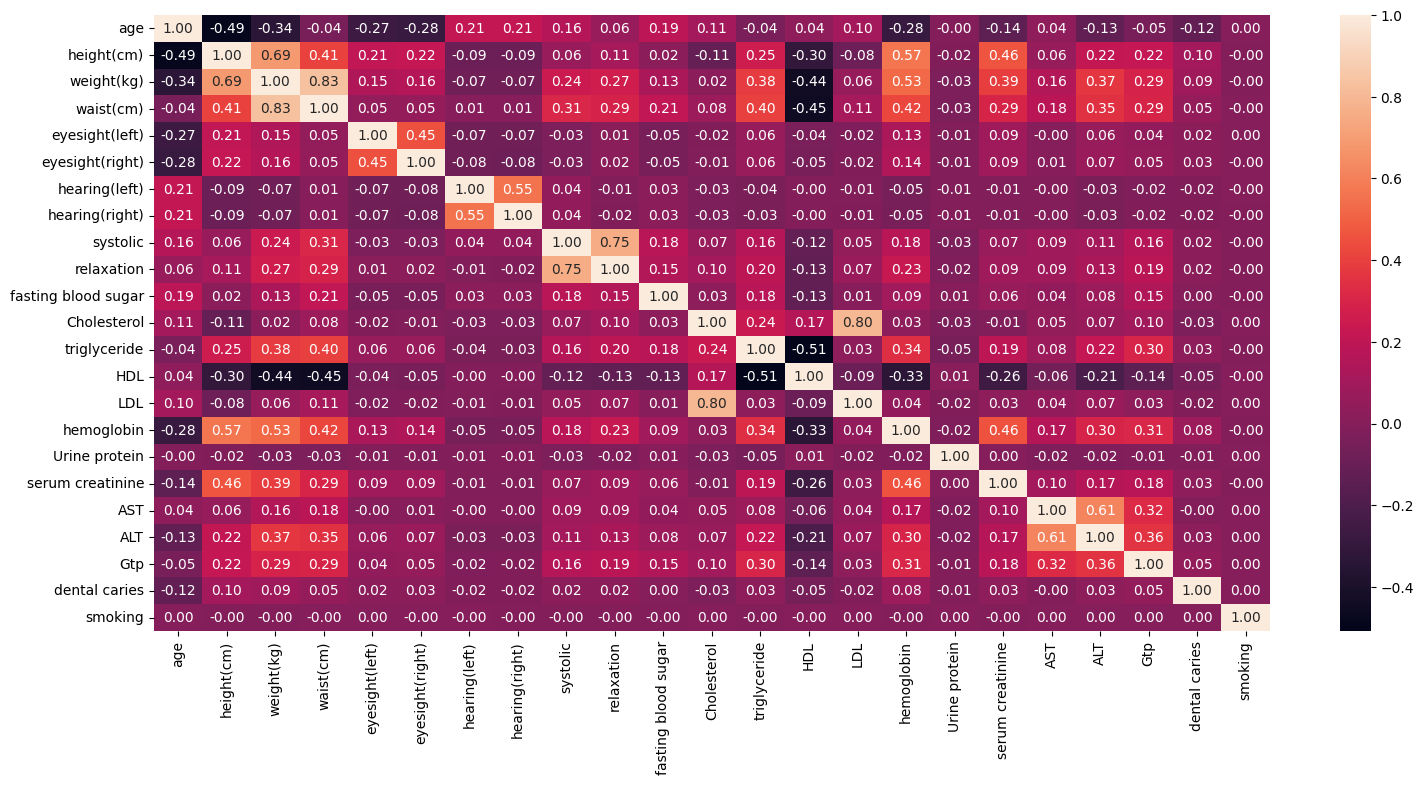

In [51]:
plt.figure(figsize=(18,8))
sns.heatmap(df_united_test.corr(), annot=True, fmt=".2f")
plt.savefig('corr.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
None

**Тест взаимной информации**

**Здесь выберем параметр score_func=mutual_info_classif, который учитывает также сложные нелинейные связи.**

In [55]:
# from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# bestfeature = SelectKBest(score_func=mutual_info_classif)
# bestfeature.fit(X_train, y_train)
# sc = bestfeature.scores_
# impt_feature = pd.DataFrame({"Feature":X_train.columns,"Score":sc})
# impt_feature = impt_feature.sort_values(by="Score",ascending=False)
# print(impt_feature)

In [57]:
# plt.figure(figsize=(8, 4))
# plt.bar(impt_feature["Feature"], impt_feature["Score"], color="skyblue")

# plt.xticks(rotation=90)
# plt.xlabel("Признаки")
# plt.ylabel("Важность признаков (Score)")
# plt.title("Важность признаков по SelectKBest")

# # Отображаем диаграмму
# plt.show()

**Наиболее коррелирующими с таргетной переменной являются следующие переменные: рост, вес, объем талии, триглицириды, гемоглобин, креатинин, gtp**

**Для части признаков создадим полиномиальные признаки, чтобы в последующем протестировать, улучшают ли они метрики. Забегая вперед, заметим, что метрики классической логистической регрессионной модели без приведенных признаков следующие.**

Accuracy: 0.7584580800723364

Precision: 0.7112643615868198

Recall: 0.7536933082566436

F1 Score: 0.7318644091425545

ROC AUC: 0.8419585393052988


**В дальнейшем мы продемонстрируем метрики моделей, обученных на датасете с включенными признаками, приведенными ниже**

Добавим полиномиальные признаки на основе исходных данных:
- индекс массы тела;
- соотношение обхвата талии к росту;
- сооотношение уровня холестерина (холестерин ЛПВП к холестерину ЛПНП).

In [61]:
X_train['BMI'] = X_train['weight(kg)'] / ((X_train['height(cm)'] / 100) **2)
X_train['waist_height_ratio'] = X_train['waist(cm)'] / X_train['height(cm)']
X_train['chol_ratio'] = X_train['LDL'] / X_train['HDL']

Также добавим данные признаки в датафрейм, который впоследствии будет очищен от выбросов

In [64]:
# df_cleaned_from_outliers['BMI'] = df_cleaned_from_outliers['weight(kg)'] / ((df_cleaned_from_outliers['height(cm)'] / 100) **2)
# df_cleaned_from_outliers['waist_height_ratio'] = df_cleaned_from_outliers['waist(cm)'] / df_cleaned_from_outliers['height(cm)']
# df_cleaned_from_outliers['chol_ratio'] = df_cleaned_from_outliers['LDL'] / df_cleaned_from_outliers['HDL']

Проверим полученные значения:

In [67]:
print(X_train[['BMI', 'waist_height_ratio', 'chol_ratio']].describe()) #проверим полученные значения

                 BMI  waist_height_ratio     chol_ratio
count  127404.000000       127404.000000  127404.000000
mean       24.442551            0.502386       2.183415
std         3.364728            0.050091       0.755167
min        11.718750            0.300000       0.021739
25%        22.038567            0.468571       1.653846
50%        24.221453            0.500000       2.144928
75%        26.159334            0.534545       2.660714
max        45.785640            0.793750      39.574468


**Посмотрим, какие значения наблюдаются в признаках**

In [70]:
X_train.head() # [159256 строк x 26 столбца]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
60700,40,150,50,80.0,0.5,0.5,1,1,120,78,...,11.8,1,0.6,14,11,9,0,22.222222,0.533333,1.816667
44065,65,150,50,69.0,0.7,1.0,1,1,139,89,...,16.3,1,0.6,17,24,25,0,22.222222,0.460000,1.820896
39538,55,155,55,80.0,1.2,1.2,1,1,109,71,...,13.4,1,0.6,19,15,16,0,22.892820,0.516129,2.000000
105427,55,160,60,83.0,0.7,0.8,1,1,130,80,...,14.6,1,0.7,14,13,26,0,23.437500,0.518750,2.944444
148669,30,180,90,95.0,1.0,1.2,1,1,120,82,...,13.8,1,0.9,25,30,21,0,27.777778,0.527778,1.592593


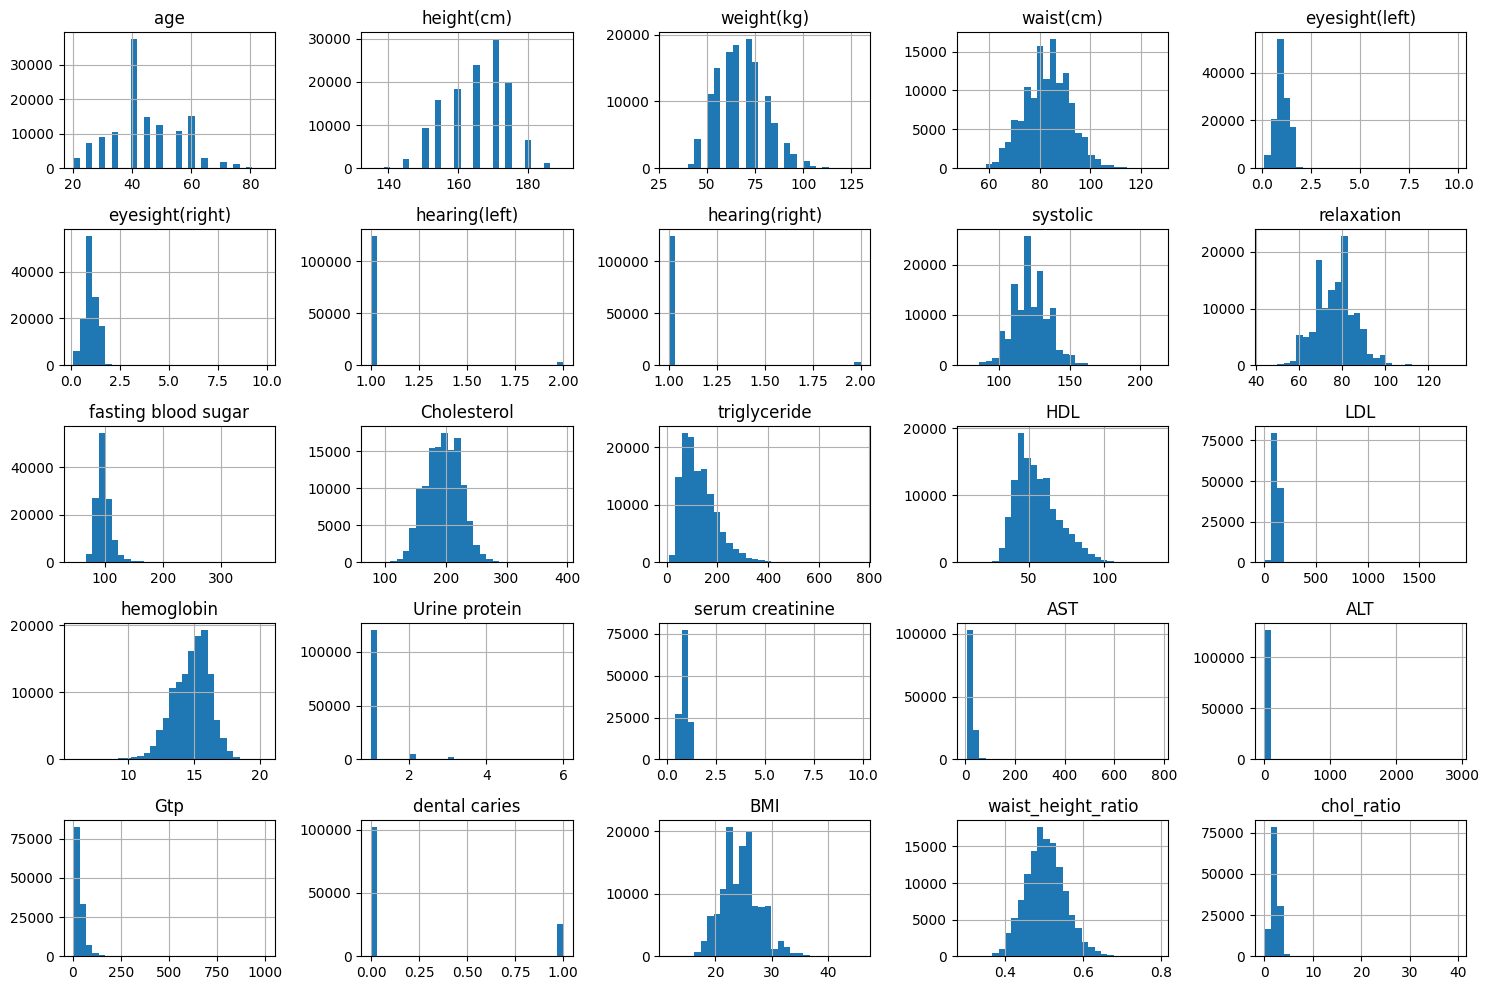

In [72]:
X_train.hist(bins=30, figsize=(15, 10))
plt.tight_layout() # подбирает оптимальное расположение подграфиков для достижения наиболее аккуратного отображения
None

**Мы обнаружили, что некоторые признаки имеют значения небольших натуральных чисел. Рассмотрим, какие значения встречаются по этим признакам, чтобы определить, имеют ли они бинарную структуру**

In [74]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(X_train))
X_train

hearing(left)
1    124376
2      3028
Name: count, dtype: int64
hearing(right)
1    124428
2      2976
Name: count, dtype: int64
Urine protein
1    120661
2      4520
3      1781
4       374
5        62
6         6
Name: count, dtype: int64
dental caries
0    102133
1     25271
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
60700,40,150,50,80.0,0.5,0.5,1,1,120,78,...,11.8,1,0.6,14,11,9,0,22.222222,0.533333,1.816667
44065,65,150,50,69.0,0.7,1.0,1,1,139,89,...,16.3,1,0.6,17,24,25,0,22.222222,0.460000,1.820896
39538,55,155,55,80.0,1.2,1.2,1,1,109,71,...,13.4,1,0.6,19,15,16,0,22.892820,0.516129,2.000000
105427,55,160,60,83.0,0.7,0.8,1,1,130,80,...,14.6,1,0.7,14,13,26,0,23.437500,0.518750,2.944444
148669,30,180,90,95.0,1.0,1.2,1,1,120,82,...,13.8,1,0.9,25,30,21,0,27.777778,0.527778,1.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,30,180,80,88.0,1.2,1.2,1,1,110,80,...,15.3,1,1.0,41,87,65,0,24.691358,0.488889,3.404762
103694,40,165,65,79.0,1.5,1.2,1,1,143,95,...,15.9,1,0.9,24,26,53,1,23.875115,0.478788,1.875000
131932,45,160,60,81.0,1.0,1.0,1,1,100,62,...,13.8,1,0.6,21,13,14,0,23.437500,0.506250,1.000000


**Таким образом, слух и кариес являются в сущности, закодированными бинарными категориальными переменными**. 

В то же время, наблюдается некоторое неединообразие, поскольку разделение в столбцах со слухом произведено по принципу 1/2, а не 0/1, как в столбце "кариес" или "курение". Поэтому было принято решение изменить кодировку на 0/1.

**Кроме того, столбец с содержанием белка в моче содержит некую градацию содержания от 1 до 6, что также указывает на то, что переменная является категориальной.**

Мы исходим из того, что 1 - это либо абсолютное, либо относительное отсутствие белка в моче (обнаружено клинически незначимое количество). Таким образом, представляется целесообразной перекодировка этого столбца на диапазон 0-5.

Перекодировка в данном случае требуется для стабильности предсказаний модели, поскольку различия в принципах классификации могут привести к ухудшениям качества модели.

**Произведем перекодировку вышеуказанных признаков**

In [77]:
columns_recoding = ['hearing(left)', 'hearing(right)', 'Urine protein']
def recoding(dataframe, is_train=True):
    for column in columns_recoding:
        dataframe[column] = dataframe[column] - 1
    return dataframe
X_train = recoding(X_train)
    

In [78]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(X_train))
X_train

hearing(left)
0    124376
1      3028
Name: count, dtype: int64
hearing(right)
0    124428
1      2976
Name: count, dtype: int64
Urine protein
0    120661
1      4520
2      1781
3       374
4        62
5         6
Name: count, dtype: int64
dental caries
0    102133
1     25271
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
60700,40,150,50,80.0,0.5,0.5,0,0,120,78,...,11.8,0,0.6,14,11,9,0,22.222222,0.533333,1.816667
44065,65,150,50,69.0,0.7,1.0,0,0,139,89,...,16.3,0,0.6,17,24,25,0,22.222222,0.460000,1.820896
39538,55,155,55,80.0,1.2,1.2,0,0,109,71,...,13.4,0,0.6,19,15,16,0,22.892820,0.516129,2.000000
105427,55,160,60,83.0,0.7,0.8,0,0,130,80,...,14.6,0,0.7,14,13,26,0,23.437500,0.518750,2.944444
148669,30,180,90,95.0,1.0,1.2,0,0,120,82,...,13.8,0,0.9,25,30,21,0,27.777778,0.527778,1.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,30,180,80,88.0,1.2,1.2,0,0,110,80,...,15.3,0,1.0,41,87,65,0,24.691358,0.488889,3.404762
103694,40,165,65,79.0,1.5,1.2,0,0,143,95,...,15.9,0,0.9,24,26,53,1,23.875115,0.478788,1.875000
131932,45,160,60,81.0,1.0,1.0,0,0,100,62,...,13.8,0,0.6,21,13,14,0,23.437500,0.506250,1.000000


**Перекодирование успешно произведено**

**Далее посмотрим, имеются ли выбросы**

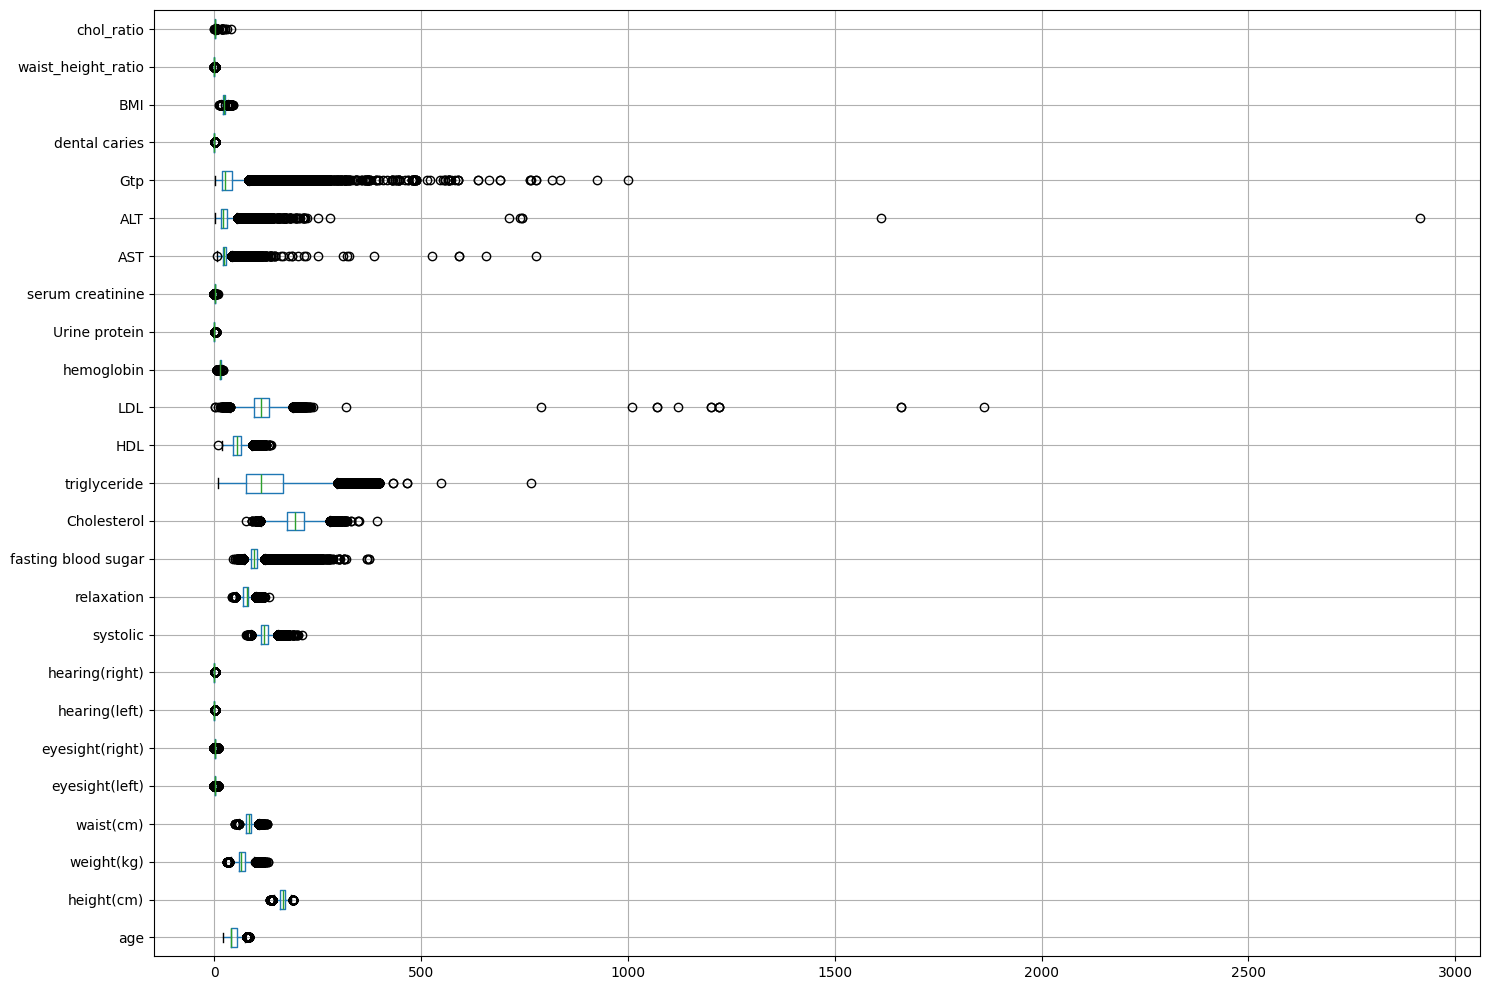

In [85]:
X_train.boxplot(figsize=(15, 10), vert=False) # Обнаружение выбросов
plt.tight_layout()

**Используем IQR для выявления и последующего удаления выбросов**

In [87]:
# columns_with_outliers = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
#        'eyesight(right)', 'systolic',
#        'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
#        'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST',
#        'ALT', 'Gtp', 'BMI', 'waist_height_ratio', 'chol_ratio']  # Все исходные столбцы, кроме категориальных

# df_cleaned_from_outliers = df_cleaned_from_outliers.copy()  #явно создаем копию, так без нее выводятся предупреждения

# for column in columns_with_outliers:
#     Q1 = df_cleaned_from_outliers.loc[:, column].quantile(0.25)  # Первый квартиль для столбца: значение, ниже которого находится 25% данных
#     Q3 = df_cleaned_from_outliers.loc[:, column].quantile(0.75)  # Третий квартиль для столбца: значение, ниже которого находится 75% данных
#     IQR = Q3 - Q1  # Межквартильный размах: разница между третьим и первым квартилем
#     lower_bound = Q1 - 1.5 * IQR # Нижняя граница. Значения за пределами нижней и верхней границы - выбросы
#     upper_bound = Q3 + 1.5 * IQR # Верхняя граница
    
#     # Добавляем новый столбец с флагами выбросов для каждого столбца
#     df_cleaned_from_outliers.loc[:, f'{column}_IQR_Outlier'] = (df_cleaned_from_outliers[column] < lower_bound) | (df_cleaned_from_outliers[column] > upper_bound)
    
#     # Считаем количество выбросов
#     outliers_number = df_cleaned_from_outliers[f'{column}_IQR_Outlier'].value_counts().get(True, 0)
#     print(f'Значений с выбросами в столбце {column}: {outliers_number}')

#     # Удаляем выбросы (значения, помеченные как True в столбце флага выбросов)
#     df_cleaned_from_outliers = df_cleaned_from_outliers[~df_cleaned_from_outliers[f'{column}_IQR_Outlier']]  # Убираем все строки с выбросами для данного столбца; ~ означает инвертирование булевой маски
    
#     # Удаляем временный столбец с флагами выбросов
#     df_cleaned_from_outliers.drop(columns=[f'{column}_IQR_Outlier'], inplace=True)

# # Выводим результат после удаления выбросов
# print(f"Осталось строк в df_cleaned_from_outliers после удаления выбросов: {df_cleaned_from_outliers.shape[0]}")

**Не привело к улучшению модели**

**Используем DBSCAN для выявления и последующего удаления выбросов**

- Попробуем подобрать оптимальные параметры гиперпараметры **eps** (радиус окрестности для каждой точки) и **min_samples** (минимальное число точек в окрестности, чтобы точка считалась кластерной).
- Предварительно произведем нормализацию, так как на исходных данных обнаружить кластеры не удается.
- Подбор оптимальных параметров произведем на небольшой выборке из исходного датафрейма ввиду ограничения мощностей.

In [93]:
# # from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import StandardScaler

# df_cleaned_sample = df_cleaned_from_outliers.sample(n=5000, random_state=42)
# df_cleaned_sample = StandardScaler().fit_transform(df_cleaned_sample)

# samples_number = np.arange(14, 19, 1) # Диапазон значений параметра min_samples, подобран тестированием различных диапазонов
# eps = np.arange(6, 7, 0.1)  # Диапазон значений параметра eps, подобран тестированием различных диапазонов


# silh = {}  # Для хранения силуэтных коэффициентов и параметров
# clusters_info = {}  # Для хранения информации о кластерах
# for n in samples_number: 
#     for e in eps:
#         clusters = DBSCAN(eps=e, min_samples=n).fit(df_cleaned_sample) #определяет кластеры для текущего набора данных
#         labels = clusters.labels_
#         n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Учитываем шумовые точки (-1)
#         if len(set(labels)) > 1:  # Убедиться, что как минимум два кластера
#             score = silhouette_score(df_cleaned_sample, labels, metric='euclidean') #silhouette_score оценивает качество кластеризации (чем ближе к 1, тем лучше)
#             silh.update({score: [e, n]})
#             clusters_info[score] = n_clusters
#         #    print(e, n, score)
#         #else:
#         #    print('Мало кластеров')


# best_score = max(silh.keys())  # Максимальный силуэтный коэффициент
# best_eps, best_min_samples = silh[best_score]
# best_n_clusters = clusters_info[best_score]
# print(f'Лучшие гиперпараметры: e={best_eps:.2f}, min_samples={best_min_samples}, silhouette_score={best_score:.4f}, кластеров: {best_n_clusters}')

Применим DBSCAN на выборке

In [96]:
# clusters = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(df_cleaned_sample)
# labels = clusters.labels_  #labels_ хранит метки, которые были присвоены каждой точке в процессе кластеризации. Если точка является выбросом, то для неё присваивается метка -1

# # Отбираем только те строки, которые не являются выбросами (не имеют метки -1)
# mask = labels != -1  # Булев массив: True для точек, которые не выбросы
# df_dbscan_cleaned = df_cleaned_sample[mask]

# # Выводим информацию об удалении выбросов
# removed_outliers = df_cleaned_sample.shape[0] - df_dbscan_cleaned.shape[0]
# print(f'Удалено {removed_outliers} выбросов.')

**Не удалось применить на всем датафрейме из-за нехватки мощностей**

**Произведение логарифмирование признаков с выбросами**

In [100]:
print(X_train.columns)

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'BMI', 'waist_height_ratio',
       'chol_ratio'],
      dtype='object')


        age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
id                                                               
60700    40         150          50       80.0             0.5   
44065    65         150          50       69.0             0.7   
39538    55         155          55       80.0             1.2   
105427   55         160          60       83.0             0.7   
148669   30         180          90       95.0             1.0   
...     ...         ...         ...        ...             ...   
119879   30         180          80       88.0             1.2   
103694   40         165          65       79.0             1.5   
131932   45         160          60       81.0             1.0   
146867   60         170          85       97.0             1.2   
121958   40         175          85       88.0             1.2   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
id                                                           

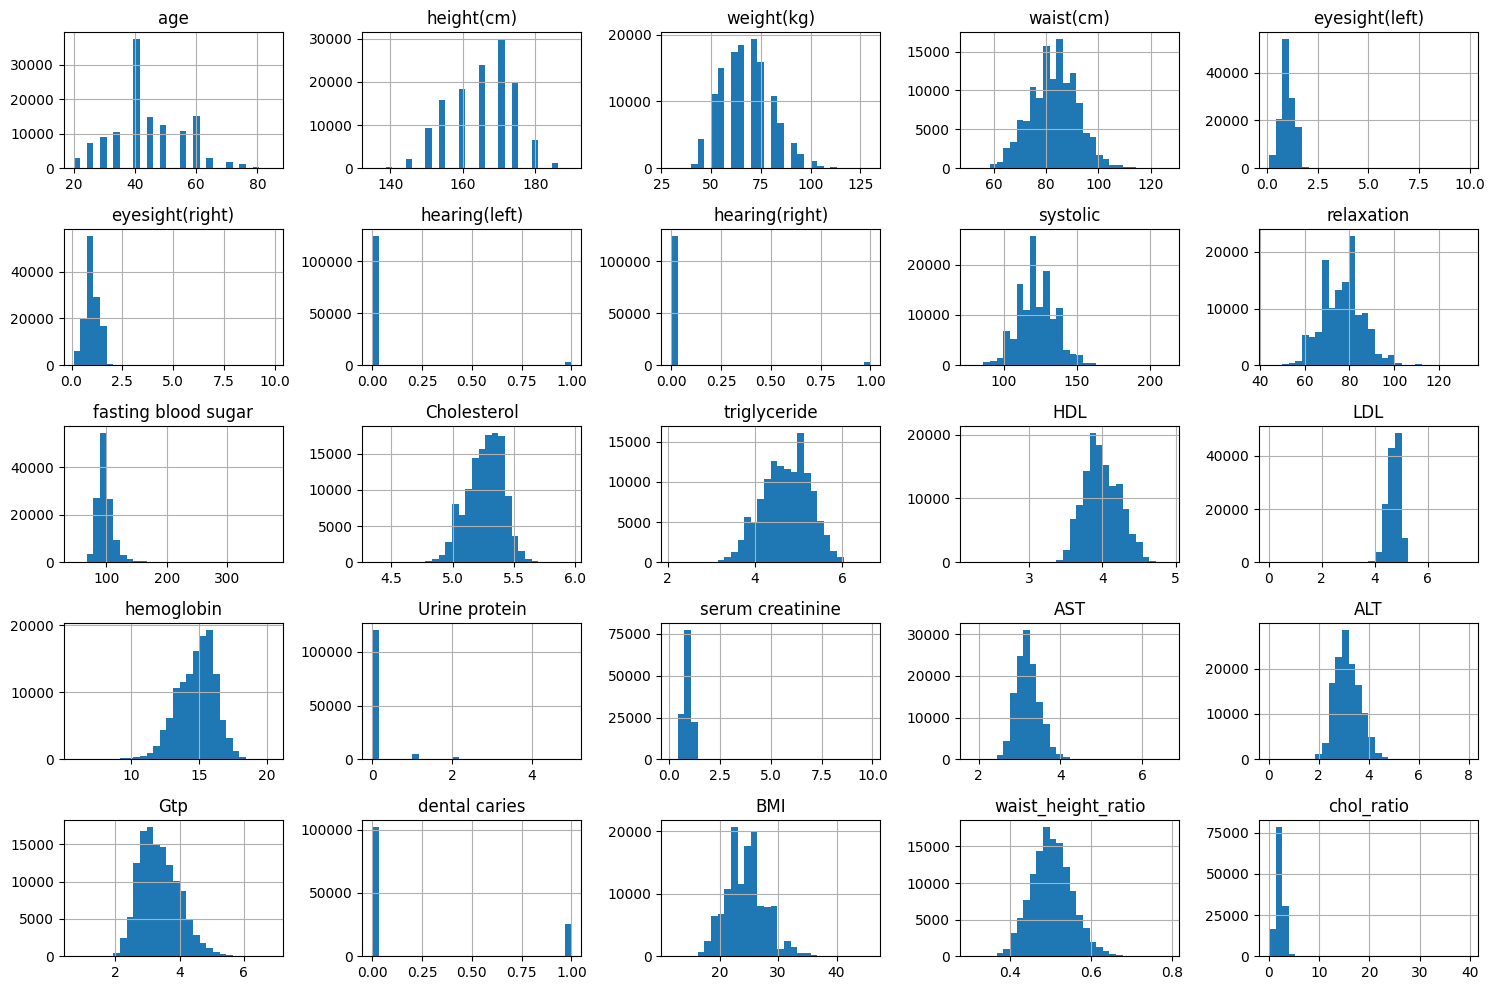

In [102]:
columns_log = ['Cholesterol','triglyceride', 'LDL', 'HDL', 'AST', 'ALT', 'Gtp'] # Находим признаки с большими выбросами, добавляем в переменную
def log_func(dataframe):
    dataframe[columns_log] = dataframe[columns_log].map(lambda x: x if x > 0 else 1) # Логарифмируем признаки с большими выбросами
    dataframe[columns_log] = np.log(dataframe[columns_log])
    dataframe.hist(bins=30, figsize=(15, 10)) # Строим гистограмму
    plt.tight_layout()
    None
    plt.savefig('g.png', dpi=600)
    return dataframe

print(log_func(X_train))

**Видим, что распределение признаков стало нормальным, более приближенным к колоколообразной форме**

**Далее стандартизируем значения числовых переменных**

In [105]:
columns_scale = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'chol_ratio', 'BMI']


In [106]:
scaler = StandardScaler()
X_train[columns_scale] = scaler.fit_transform(X_train[columns_scale])
X_train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
60700,-0.363764,-1.729695,-1.361653,-0.333247,-1.261648,-1.278404,0,0,-0.194342,0.127119,...,-2.090771,0,-1.626365,-1.853242,-1.508253,-1.883575,0,-0.659886,0.533333,-0.485654
44065,1.750195,-1.729695,-1.361653,-1.563035,-0.762843,-0.002432,0,0,1.298727,1.348476,...,1.052672,0,-1.626365,-1.202135,0.062841,-0.243222,0,-0.659886,0.460000,-0.480054
39538,0.904612,-1.162983,-0.963707,-0.333247,0.484171,0.507957,0,0,-1.058751,-0.650109,...,-0.973102,0,-1.626365,-0.829138,-0.883659,-0.959776,0,-0.460583,0.516129,-0.242881
105427,0.904612,-0.596270,-0.565762,0.002149,-0.762843,-0.512820,0,0,0.591484,0.349184,...,-0.134851,0,-1.071018,-1.853242,-1.171837,-0.180250,0,-0.298703,0.518750,1.007766
148669,-1.209348,1.670580,1.821910,1.343736,-0.014635,0.507957,0,0,-0.194342,0.571249,...,-0.693685,0,0.039675,0.091192,0.512210,-0.523162,0,0.991236,0.527778,-0.782376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-1.209348,1.670580,1.026020,0.561144,0.484171,0.507957,0,0,-0.980168,0.349184,...,0.354129,0,0.595022,1.750167,2.656339,1.290937,0,0.073946,0.488889,1.617325
103694,-0.363764,-0.029558,-0.167816,-0.445046,1.232379,0.507957,0,0,1.613058,2.014671,...,0.773255,0,0.039675,-0.045705,0.224032,0.963243,1,-0.168643,0.478788,-0.408408
131932,0.059028,-0.596270,-0.565762,-0.221448,-0.014635,-0.002432,0,0,-1.765994,-1.649402,...,-0.693685,0,-1.626365,-0.493505,-1.171837,-1.174173,0,-0.298703,0.506250,-1.567097


**Таким образом, датасет предобработан, готов к анализу и построению модели**

**На данном этапе мы приняли решение о предобработке тестовой выборки, чтобы убедиться, что все функции работают исправно**

**Убедились, что все столбцы из тренировочной выборки присутствуют (за исключением таргетной переменной). Далее запустим ранее сформированные функции для предобработки датасета. На данном этапе закомментируем этот блок**

Количество признаков, содержащих пропущенные значения: 0
Количество пропущенных значений: 0
Количество нулевых строк: 0
Дубликаты: Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries, BMI, waist_height_ratio, chol_ratio]
Index: []

[0 rows x 25 columns]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
145654,-0.786556,1.103867,1.026020,0.113948,-0.513440,-0.002432,0,0,-0.037177,-0.761141,...,0.843109,0,-1.071018,0.812573,-0.112384,0.153133,0,0.499269,0.480000,-0.002115
49118,-0.786556,2.237292,1.026020,0.561144,0.484171,0.507957,0,0,-1.765994,-1.427337,...,0.144566,0,0.039675,-0.337500,-0.112384,-0.862438,0,-0.317360,0.475676,-0.729328
21769,-2.054932,-0.596270,-0.565762,-0.780443,0.484171,0.507957,0,0,0.591484,0.904346,...,1.471798,0,-0.515671,-0.045705,0.642179,0.551057,1,-0.298703,0.475000,2.327654
108299,1.327404,-1.162983,-0.565762,0.538784,-0.762843,-2.043987,0,0,-0.272925,-1.649402,...,-1.112811,0,0.039675,-0.493505,-0.753690,-1.174173,0,0.157943,0.566452,0.138057
117130,1.327404,-0.029558,0.230129,0.225747,-0.513440,-1.023209,0,0,1.534475,1.792606,...,0.493838,0,-1.071018,0.349283,1.091548,1.188960,0,0.377182,0.515152,0.027367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,-1.632140,-0.029558,-0.565762,-0.735723,1.232379,-1.278404,0,0,-0.980168,-0.761141,...,-0.134851,0,-1.071018,-0.337500,0.642179,-0.862438,0,-0.714469,0.463030,-0.613662
115975,-0.363764,-1.162983,-0.167816,0.002149,-0.014635,-0.002432,0,0,1.377310,2.569834,...,-0.344414,0,-1.626365,-0.337500,0.224032,-0.523162,0,0.776470,0.535484,-1.428516
158289,-0.363764,1.103867,0.230129,0.113948,0.484171,0.507957,0,0,-0.430090,-1.316304,...,1.052672,0,1.150368,-0.188430,0.224032,1.240758,0,-0.471186,0.480000,0.314683


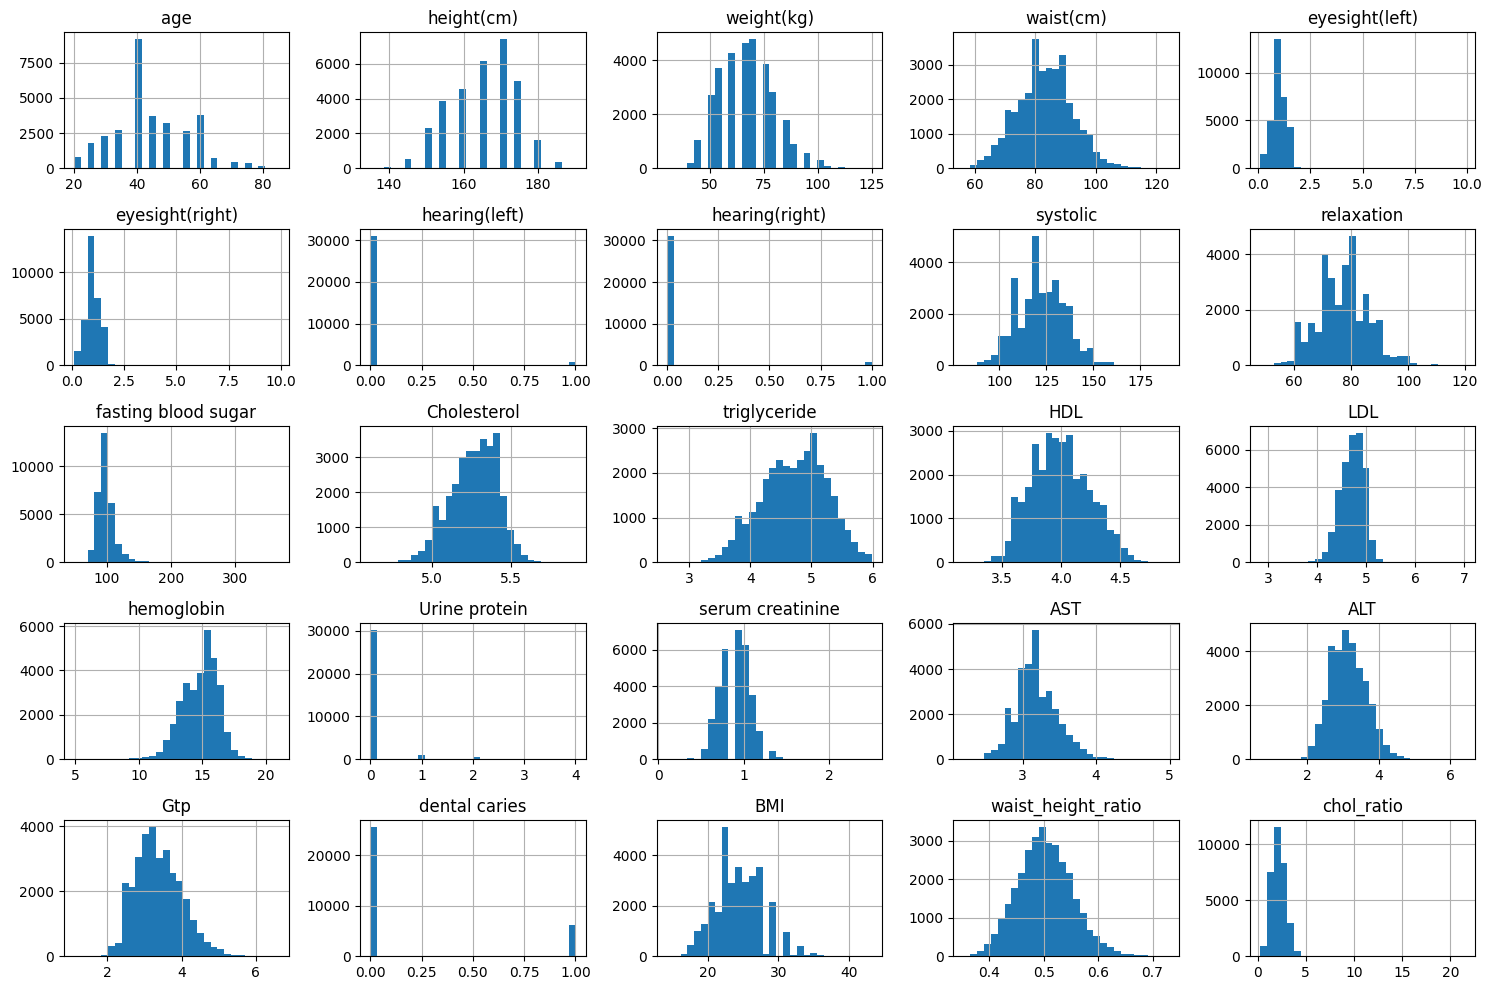

In [110]:
X_test['BMI'] = X_test['weight(kg)'] / ((X_test['height(cm)'] / 100) **2)
X_test['waist_height_ratio'] = X_test['waist(cm)'] / X_test['height(cm)']
X_test['chol_ratio'] = X_test['LDL'] / X_test['HDL']
X_test = duplicates_nan(X_test)
X_test = recoding(X_test)
X_test = log_func(X_test)
X_test[columns_scale] = scaler.transform(X_test[columns_scale])
X_test

**Мы завершили преобработку тестовой выборки и перешли к созданию модели ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ, ее обучению и предсказаниям**

In [114]:
model = LogisticRegression(solver='liblinear', random_state=42)

In [115]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_test)

**Оценим качество предсказания на тестовой выборке на данных, прошедшей стандартный препроцессинг (стандартизация, логарифмирование, перекодировка, добавление новых признаков)**

In [117]:
accuracy = accuracy_score(y_test, y_train_pred)
precision = precision_score(y_test, y_train_pred)
recall = recall_score(y_test, y_train_pred)
f1 = f1_score(y_test, y_train_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7564046213738541
Precision: 0.712945464362851
Recall: 0.7507996303930627
F1 Score: 0.731383070797992
ROC AUC: 0.8396367279529011


**Вывод: модель демонстрирует среднее качество. Мы использовали кросс-валидацию для отбора лучших параметров модели. Между тем, на данном этапе модель с другими параметрами не продемонстрировала ощутимого улучшения метрик (все улучшения были в масштабе 0.01%), поэтому тонкая настройка была исключена из настоящего файла**

**Замечание: добавление новых признаков продемонстрировало незначительное улучшение (по сравнению с бэйзлайн моделью) метрики accuracy и сопоставимое снижение некоторых других метрик. Было принято решение оставить эти признаки для целей дальнейшего построения полиномиальной модели логистической регрессии**


**Дополнительно исследуем ПОЛИНОМИАЛЬНУЮ модель, которая возводит признаки в степень для поиска нелинейной связи, что косвенно относится также к обработке признаков**

**При повторном исследовании полиномиальной модели было принято решение предварительно проверить дисбаланс классов**

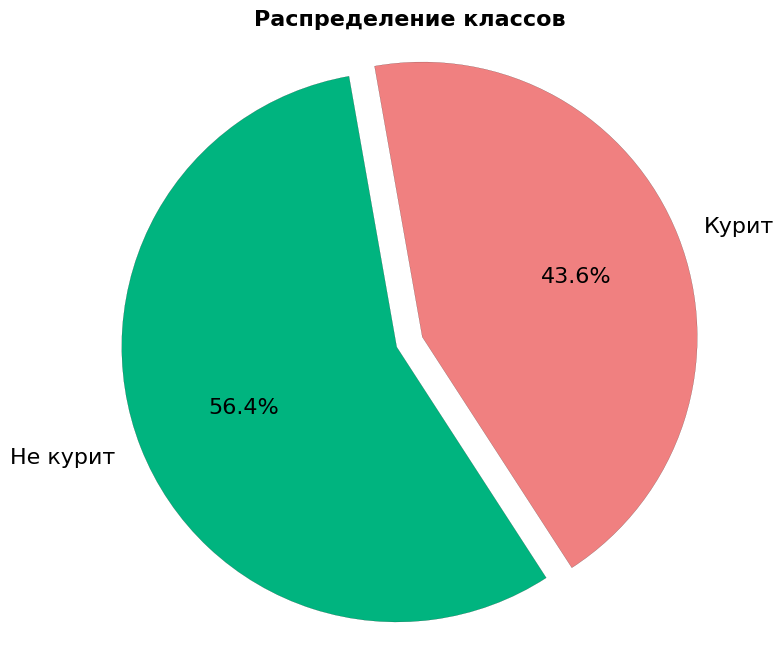

In [144]:
target_counts = y_train.value_counts()

plt.figure(figsize=(8, 8))

explode = (0, 0.1)

plt.pie(
    target_counts, 
    labels=['Не курит', 'Курит'], 
    autopct='%1.1f%%', 
    startangle=100, 
    colors=['#00B47F', 'lightcoral'], 
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.1},
    shadow=False,  # Убираем тень или делаем её менее выраженной
    textprops={'fontsize': 16}  # Увеличиваем шрифт лэйблов
)

plt.title('Распределение классов', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.savefig('classes.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()


**Как видно, существенного дисбаланса нет, однако мы затестируем SMOT, который может добавить синтетических соседей для класса курильщиков, чтобы модель лучше обучилась**

In [149]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [150]:
columns_polynome = ['hemoglobin', 'height(cm)', 'weight(kg)', 'Gtp', 'Cholesterol', 'BMI', 'waist_height_ratio',
       'chol_ratio', 'systolic',
       'relaxation', 'age', 'AST',
       'ALT', 'dental caries', 'triglyceride', 'HDL', 'LDL']

**Далее обучим ПОЛИНОМИАЛЬНУЮ модель логистической регрессии, а также настроим оптимальные параметры для логистической регрессии (процесс отбора параметров исключен из файла для разгрузки документа)**

In [152]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


model2 = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(solver='lbfgs', max_iter=10000, C=0.1, class_weight='balanced'))
model2.fit(X_resampled[columns_polynome], y_resampled)
y_train_pred_2 = model2.predict(X_resampled[columns_polynome])
accuracy_2 = accuracy_score(y_resampled, y_train_pred_2)
precision_2 = precision_score(y_resampled, y_train_pred_2)
recall_2 = recall_score(y_resampled, y_train_pred_2)
f1_2 = f1_score(y_resampled, y_train_pred_2)
roc_auc_2 = roc_auc_score(y_resampled, model2.predict_proba(X_resampled[columns_polynome])[:, 1])


print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision_2}')
print(f'Recall: {recall_2}')
print(f'F1 Score: {f1_2}')
print(f'ROC AUC: {roc_auc_2}')

Accuracy: 0.7831105541631858
Precision: 0.7433166598855994
Recall: 0.8648844333054859
F1 Score: 0.7995057469784923
ROC AUC: 0.8569137551170851


**Вывод: для обучения ПОЛИНОМИАЛЬНОЙ модели были взяты практически все признаки, которые у нас хватило производительности обработать. Наблюдаем улучшение качества модели. Предполагаем, что связь ряда признаков с таргетной переменной может быть нелинейной.**

**Также проверим модель на валидационной выборке, чтобы убедиться, что модель не переобучилась**

In [162]:
y_test_pred3 = model2.predict(X_test[columns_polynome])
accuracy_3 = accuracy_score(y_test, y_test_pred3)
precision_3 = precision_score(y_test, y_test_pred3)
recall_3 = recall_score(y_test, y_test_pred3)
f1_3 = f1_score(y_test, y_test_pred3)
roc_auc_3 = roc_auc_score(y_test, model2.predict_proba(X_test[columns_polynome])[:, 1])


print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision_3}')
print(f'Recall: {recall_3}')
print(f'F1 Score: {f1_3}')
print(f'ROC AUC: {roc_auc_3}')

Accuracy: 0.7655720205952531
Precision: 0.6898872526461114
Recall: 0.852441538133485
F1 Score: 0.7625981623374559
ROC AUC: 0.849859246624753


**Метрики стабильны, за исключением precision-recall. Модель стала предсказывать чаще класс 1 (несмотря на балансировку). Таким образом, полиномиальная модель логистической регрессии демонстрирует позитивную тенденцию в части предсказательной способности, однако вероятнее всего требуется работа с дисбалансом классов**

**Попробуем другие инструменты. На текущий момент зафиксируем те метрики, которые у нас уже есть**

**Попробуем посмотреть, как отработает дерево**

**Рандомный отбор параметров продемонстрировал плохие метрики, поэтому пробуем оптуну**

In [169]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
import optuna
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 60)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 60)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        criterion=criterion
    )
    
    # Кросс-валидация для оценки модели
    f1 = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=5).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f'Лучшие параметры: {study.best_params}')

best_params = study.best_params
best_model2 = tree.DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_leaf_nodes=best_params['max_leaf_nodes'],
    criterion=best_params['criterion']
)

[I 2024-12-13 12:30:21,321] A new study created in memory with name: no-name-2703d4cd-a1e4-47ae-85fc-9bca11568b4c
[I 2024-12-13 12:30:22,974] Trial 0 finished with value: 0.7508655488888206 and parameters: {'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 45, 'max_leaf_nodes': 43, 'criterion': 'gini'}. Best is trial 0 with value: 0.7508655488888206.
[I 2024-12-13 12:30:24,603] Trial 1 finished with value: 0.7556930129931942 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 55, 'max_leaf_nodes': 28, 'criterion': 'gini'}. Best is trial 1 with value: 0.7556930129931942.
[I 2024-12-13 12:30:26,107] Trial 2 finished with value: 0.7513635111555421 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 55, 'max_leaf_nodes': 20, 'criterion': 'gini'}. Best is trial 1 with value: 0.7556930129931942.
[I 2024-12-13 12:30:27,046] Trial 3 finished with value: 0.7280389872612152 and parameters: {'max_depth': 3, 'min_samples_split': 15, 'mi

Лучшие параметры: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 32, 'max_leaf_nodes': 41, 'criterion': 'entropy'}


In [170]:
best_model2.fit(X_train, y_train)

y_train_pred_opt = best_model2.predict(X_train)


print(f"F1 на тренировочной выборке: {f1_score(y_train, y_train_pred_opt, average='weighted')}")

F1 на тренировочной выборке: 0.7568453893123591


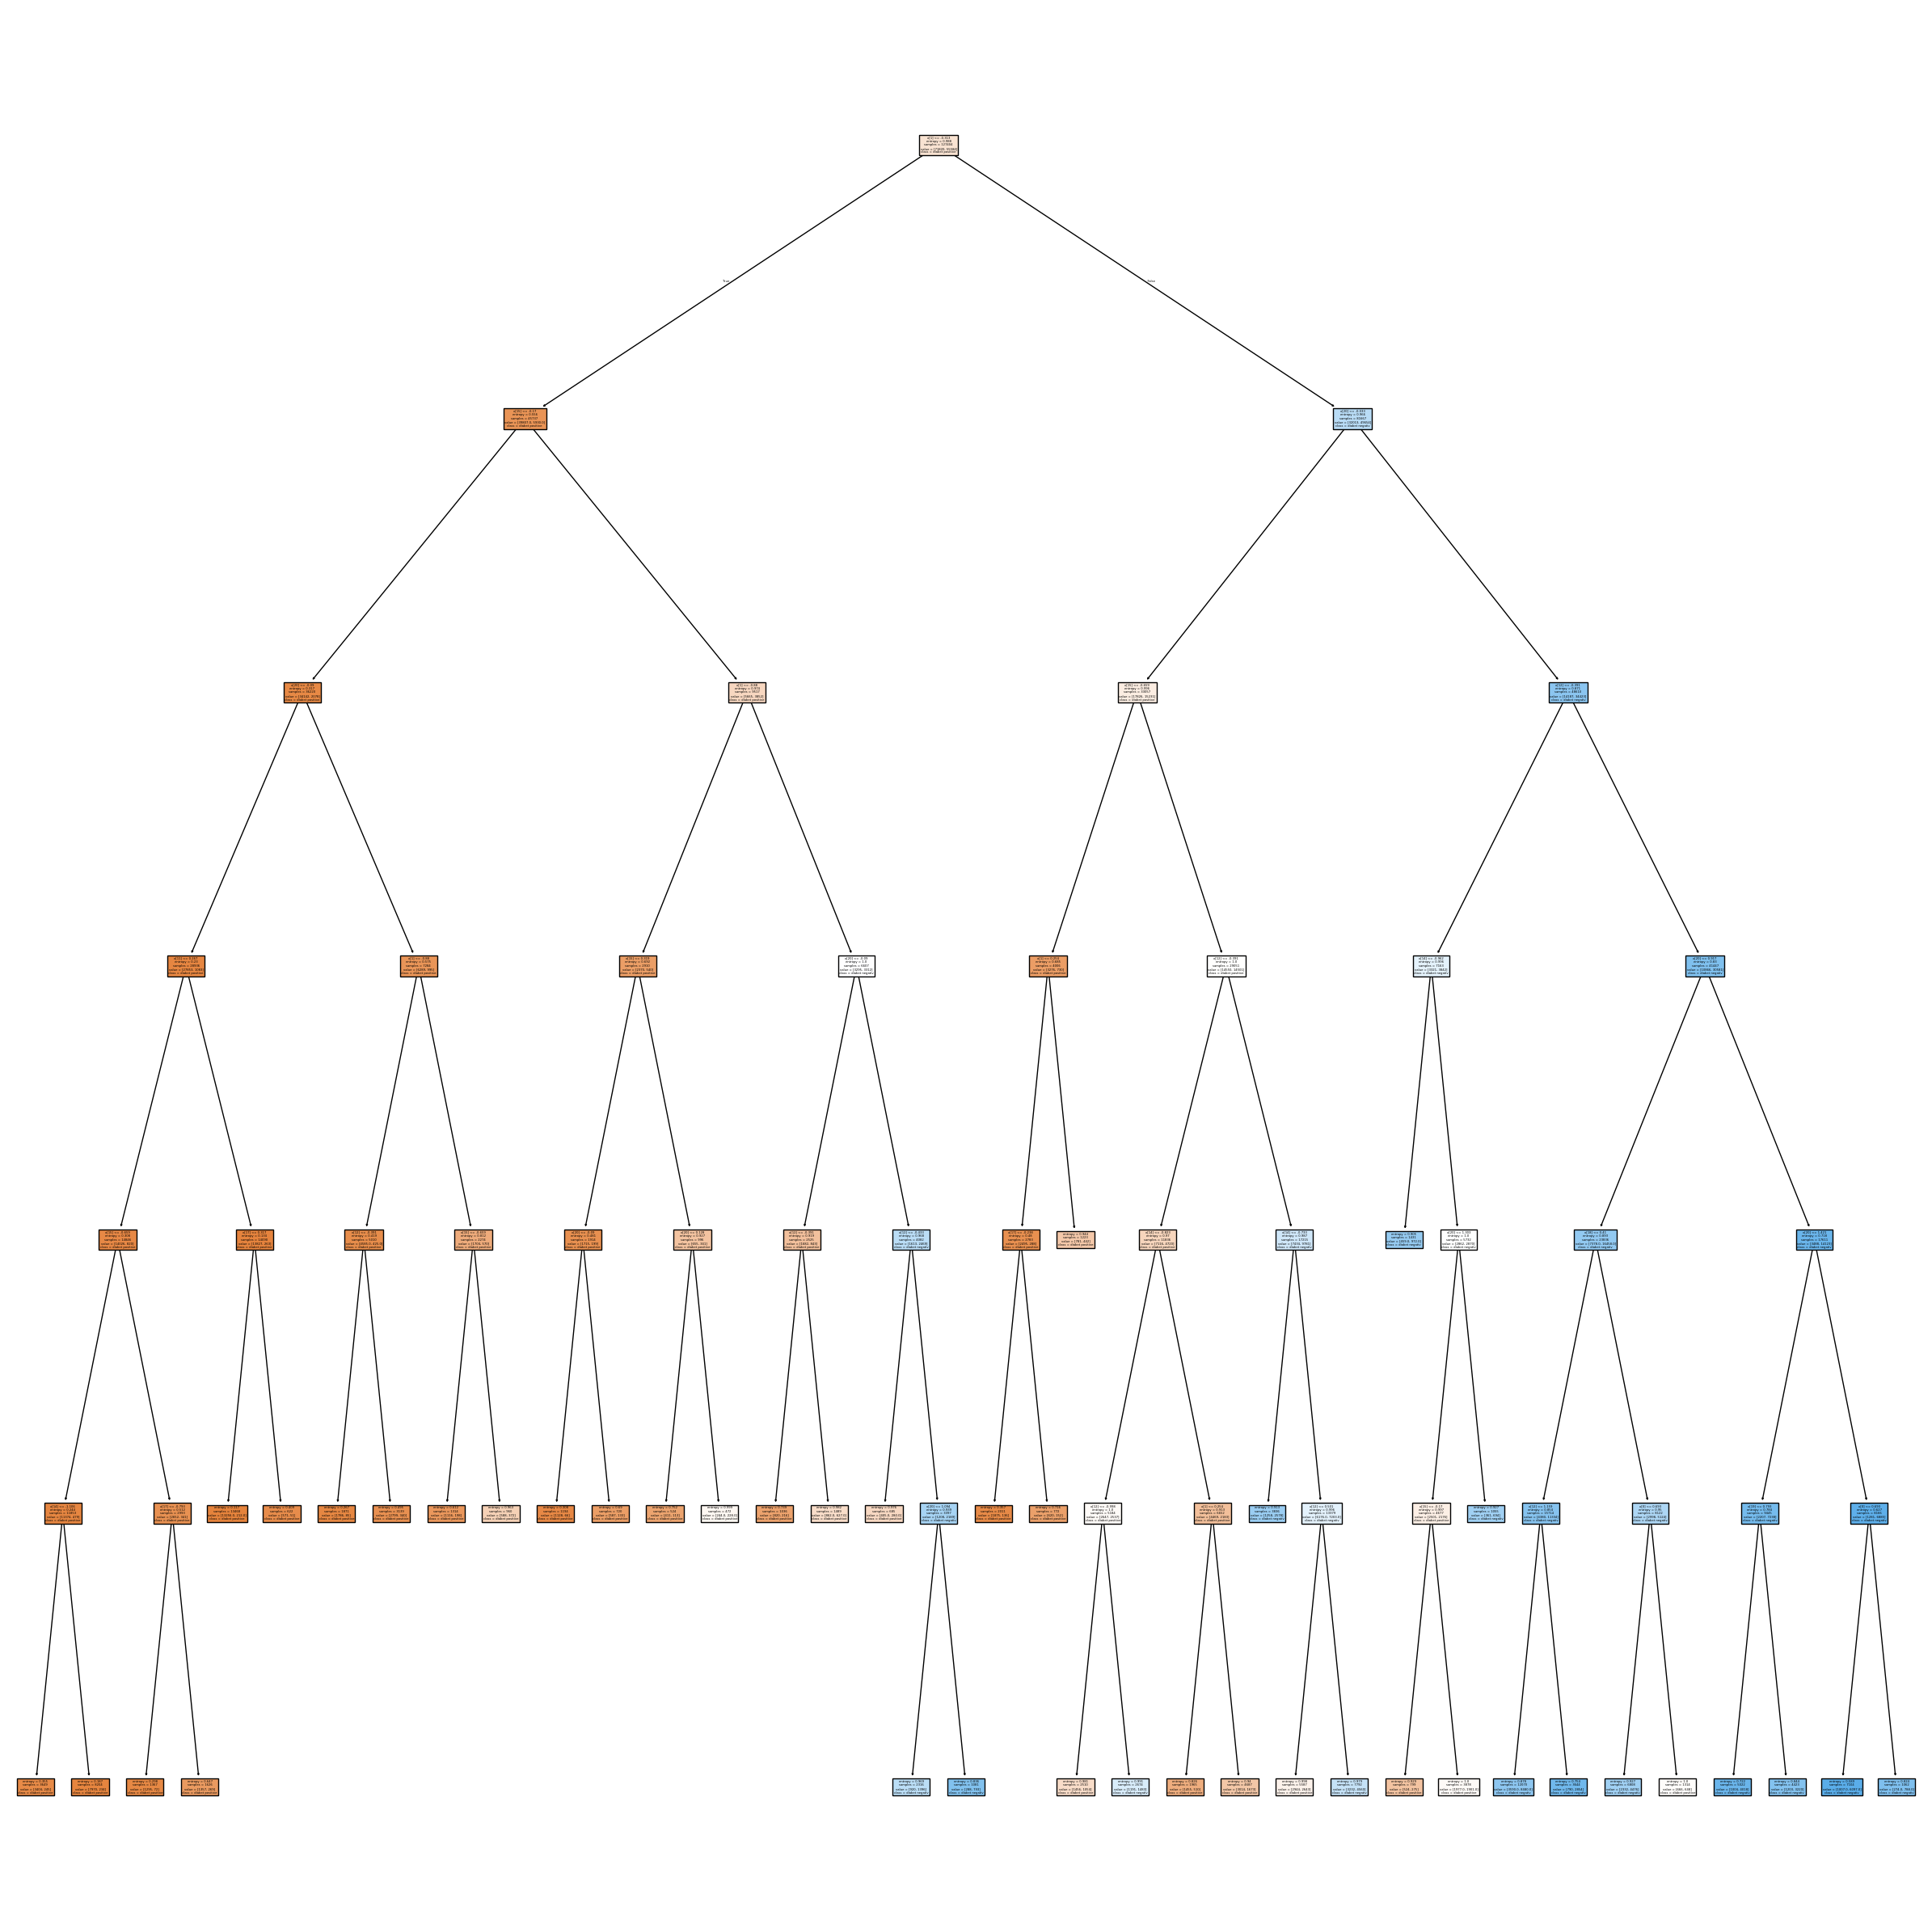

In [158]:
plt.figure(figsize=(24, 24))
tree.plot_tree(best_model2, class_names=['diabet positive', 'diabet negativ'], filled=True)
plt.tight_layout()
None

In [173]:
accuracy_train_opt = accuracy_score(y_train, y_train_pred_opt)
precision_train_opt = precision_score(y_train, y_train_pred_opt)
recall_train_opt = recall_score(y_train, y_train_pred_opt)
roc_auc_train_opt = roc_auc_score(y_train, best_model2.predict_proba(X_train)[:, 1])

print(f'Accuracy для тестовой: {accuracy_train_opt }')
print(f'Precision для тестовой: {precision_train_opt}')
print(f'Recall для тестовой: {recall_train_opt}')
print(f'ROC AUC для тестовой: {roc_auc_train_opt}')

Accuracy для тестовой: 0.7560202191453957
Precision для тестовой: 0.7030902881395271
Recall для тестовой: 0.7629713586643638
ROC AUC для тестовой: 0.8357979490190246


**Дерево выглядит довольно громоздко, хотя метрики продемонстрировало неплохие. Попробуем поработать в этом направлении**


**НЕ ПЕРЕЗАПУСКАТЬ!!!
Попробуем использовать ансамблевый (деревья, лес) градиентный бустинг**

In [245]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

y_train = y_train.ravel()
y_test = y_test.ravel()

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 50),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    }
    model4 = XGBClassifier(**param)
    model4.fit(X_train, y_train)
    y_pred4 = model4.predict(X_test)
    return f1_score(y_test, y_pred4) 


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


print("Лучшие параметры:", study.best_params)
print("Лучший F1-score на обучении:", study.best_value)


best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)


y_test_pred = best_model.predict(X_test)


f1_best = f1_score(y_test, y_test_pred)
accuracy_best = accuracy_score(y_test, y_test_pred)

print(f'F1 Score of best model: {f1_best}')
print(f'Accuracy of best model: {accuracy_best}')

[I 2024-12-05 18:34:43,206] A new study created in memory with name: no-name-d87dcdb6-3f13-417c-8175-cf16587efdbf
[I 2024-12-05 18:34:46,012] Trial 0 finished with value: 0.774761508419233 and parameters: {'max_depth': 3, 'learning_rate': 0.15180261711516557, 'n_estimators': 579, 'colsample_bytree': 0.9677135888037434, 'min_child_weight': 6, 'subsample': 0.9519614537716012, 'colsample_bylevel': 0.7494616913766908, 'colsample_bynode': 0.8394381676355717, 'max_delta_step': 36}. Best is trial 0 with value: 0.774761508419233.
[I 2024-12-05 18:34:50,938] Trial 1 finished with value: 0.7764759045866821 and parameters: {'max_depth': 3, 'learning_rate': 0.286556051096985, 'n_estimators': 881, 'colsample_bytree': 0.6780794857495402, 'min_child_weight': 7, 'subsample': 0.8607954635659916, 'colsample_bylevel': 0.7442931921834796, 'colsample_bynode': 0.8916954166069389, 'max_delta_step': 42}. Best is trial 1 with value: 0.7764759045866821.
[I 2024-12-05 18:34:52,537] Trial 2 finished with value: 0

Лучшие параметры: {'max_depth': 3, 'learning_rate': 0.286556051096985, 'n_estimators': 881, 'colsample_bytree': 0.6780794857495402, 'min_child_weight': 7, 'subsample': 0.8607954635659916, 'colsample_bylevel': 0.7442931921834796, 'colsample_bynode': 0.8916954166069389, 'max_delta_step': 42}
Лучший F1-score на обучении: 0.7764759045866821
F1 Score of best model: 0.7638388915302587
Accuracy of best model: 0.7816777596383273


In [253]:
accuracy_test_xgb = accuracy_score(y_test, y_test_pred)
precision_test_xgb = precision_score(y_test, y_test_pred)
recall_test_xgb = recall_score(y_test, y_test_pred)
roc_auc_test_xgb = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f'Accuracy для тестовой: {accuracy_test_xgb}')
print(f'Precision для тестовой: {precision_test_xgb}')
print(f'Recall для тестовой: {recall_test_xgb}')
print(f'F1 Score для тестовой: {f1_best}')
print(f'ROC AUC для тестовой: {roc_auc_test_xgb}')


Accuracy для тестовой: 0.7816777596383273
Precision для тестовой: 0.7313520192495285
Recall для тестовой: 0.7993460800341176
F1 Score для тестовой: 0.7638388915302587
ROC AUC для тестовой: 0.8645076828249546


**Опять же наблюдаем улучшение метрик, разрыв между Precision и Recall сокращается, что указывает на то, что бустинг неплохо балансирует классы.**

Часть ниже оставлена для истории. Мы пробовали использовать SMOTE-преобразованные выборки со всеми инструментами, однако к улучшению метрик этот инструмент привел только на полиномиальной модели (ранее). Вероятно, SMOTE конфликтует с балансировкой, используемой на бустинге. Таким образом, мы используем обычные выборки, небалансированные через SMOTE. Метрики на xgb & SMOT 

F1 Score of best model: 0.7684984570940845
Accuracy of best model: 0.7786010297626522

In [229]:
# def objective(trial):
#     param = {
#         'objective': 'binary:logistic',  # Для бинарной классификации
#         'random_state': 42,
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 250),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
#         'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
#         'max_delta_step': trial.suggest_int('max_delta_step', 0, 50),
#         'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Для несбалансированных данных
#     }
#     model4 = XGBClassifier(**param)
#     model4.fit(X_resampled, y_resampled)
#     y_pred4 = model4.predict(X_test)
#     return f1_score(y_test, y_pred4)  # F1-score для бинарной задачи


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)


# print("Лучшие параметры:", study.best_params)
# print("Лучший F1-score на обучении:", study.best_value)


# best_model = XGBClassifier(**study.best_params)
# best_model.fit(X_resampled, y_resampled)


# y_test_pred = best_model.predict(X_test)


# f1_best = f1_score(y_test, y_test_pred)
# accuracy_best = accuracy_score(y_test, y_test_pred)

# print(f'F1 Score of best model: {f1_best}')
# print(f'Accuracy of best model: {accuracy_best}')

**Посмотрим, как отработает голосующий классификатор, будем использовать три вида бустинга (xgb, catboost, lgbm)**

In [127]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

xgb_model = XGBClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
catboost_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_catboost = catboost_model.predict(X_test)

y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost)
precision_catboost = precision_score(y_test, y_pred_catboost)
recall_catboost = recall_score(y_test, y_pred_catboost)
roc_auc_catboost = roc_auc_score(y_test, y_pred_proba_catboost)

voting_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model)
], voting='soft')


voting_model.fit(X_train, y_train)


y_pred_vote = voting_model.predict(X_test)
y_pred_proba_vote = voting_model.predict_proba(X_test)[:, 1]


accuracy_vote = accuracy_score(y_test, y_pred_vote)
f1_vote = f1_score(y_test, y_pred_vote)
precision_vote = precision_score(y_test, y_pred_vote)
recall_vote = recall_score(y_test, y_pred_vote)
roc_auc_vote = roc_auc_score(y_test, y_pred_proba_vote)


print(f"XGBoost - Accuracy: {accuracy_xgb}, F1-Score: {f1_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, ROC AUC: {roc_auc_xgb}")
print(f"LightGBM - Accuracy: {accuracy_lgbm}, F1-Score: {f1_lgbm}, Precision: {precision_lgbm}, Recall: {recall_lgbm}, ROC AUC: {roc_auc_lgbm}")
print(f"CatBoost - Accuracy: {accuracy_catboost}, F1-Score: {f1_catboost}, Precision: {precision_catboost}, Recall: {recall_catboost}, ROC AUC: {roc_auc_catboost}")
print(f"Voting Classifier - Accuracy: {accuracy_vote}, F1-Score: {f1_vote}, Precision: {precision_vote}, Recall: {recall_vote}, ROC AUC: {roc_auc_vote}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55584, number of negative: 71820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436281 -> initscore=-0.256268
[LightGBM] [Info] Start training from score -0.256268
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55584, number of negative: 71820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

In [129]:
print(f'Accuracy для тестовой: {accuracy_vote}')
print(f'Precision для тестовой: {precision_vote}')
print(f'Recall для тестовой: {recall_vote}')
print(f'F1 Score для тестовой: {f1_vote}')
print(f'ROC AUC для тестовой: {roc_auc_vote}')


Accuracy для тестовой: 0.7823056636945874
Precision для тестовой: 0.7269835210281861
Recall для тестовой: 0.8121401663231218
F1 Score для тестовой: 0.7672060699657557
ROC AUC для тестовой: 0.8650790148362502


**Глобально улучшений нет, потому что как видно из результатов, основной вес скорее всего вносит XGBoost, который уже дал лучшие метрики раньше. Приведем их тут:**

Accuracy для тестовой: 0.7810812507848801

Precision для тестовой: 0.7262755102040817

Recall для тестовой: 0.8094391925509986

F1 Score для тестовой: 0.7656055665736663

ROC AUC для тестовой: 0.8643528518938602

**Попробуем использовать этот бустинг вместе с полиномиальной моделью**

In [133]:
polymod = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = polymod.fit_transform(X_train)
X_test_poly = polymod.transform(X_test)


xgb_model1 = XGBClassifier(random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
lgbm_model1 = LGBMClassifier(random_state=42, class_weight='balanced')
catboost_model1 = CatBoostClassifier(random_state=42, verbose=0, class_weights=[1, (len(y_train) - sum(y_train)) / sum(y_train)])

xgb_model1.fit(X_train_poly, y_train)
lgbm_model1.fit(X_train_poly, y_train)
catboost_model1.fit(X_train_poly, y_train)


y_pred_xgb1 = xgb_model1.predict(X_test_poly)
y_pred_proba_xgb1 = xgb_model1.predict_proba(X_test_poly)[:, 1]

y_pred_lgbm1 = lgbm_model1.predict(X_test_poly)
y_pred_proba_lgbm1 = lgbm_model1.predict_proba(X_test_poly)[:, 1]

y_pred_catboost1 = catboost_model1.predict(X_test_poly)
y_pred_proba_catboost1 = catboost_model1.predict_proba(X_test_poly)[:, 1]


accuracy_xgb1 = accuracy_score(y_test, y_pred_xgb1)
f1_xgb1 = f1_score(y_test, y_pred_xgb1)
precision_xgb1 = precision_score(y_test, y_pred_xgb1)
recall_xgb1 = recall_score(y_test, y_pred_xgb1)

accuracy_lgbm1 = accuracy_score(y_test, y_pred_lgbm1)
f1_lgbm1 = f1_score(y_test, y_pred_lgbm1)
precision_lgbm1 = precision_score(y_test, y_pred_lgbm1)
recall_lgbm1 = recall_score(y_test, y_pred_lgbm1)

accuracy_catboost1 = accuracy_score(y_test, y_pred_catboost1)
f1_catboost1 = f1_score(y_test, y_pred_catboost1)
precision_catboost1 = precision_score(y_test, y_pred_catboost1)
recall_catboost1 = recall_score(y_test, y_pred_catboost1)


voting_model1 = VotingClassifier(estimators=[
    ('xgb', xgb_model1),
    ('lgbm', lgbm_model1),
    ('catboost', catboost_model1)
], voting='soft')


voting_model1.fit(X_train_poly, y_train)


y_pred_vote1 = voting_model1.predict(X_test_poly)
y_pred_proba_vote1 = voting_model1.predict_proba(X_test_poly)[:, 1]


accuracy_vote1 = accuracy_score(y_test, y_pred_vote1)
f1_vote1 = f1_score(y_test, y_pred_vote1)
precision_vote1 = precision_score(y_test, y_pred_vote1)
recall_vote1 = recall_score(y_test, y_pred_vote1)
roc_auc_vote1 = roc_auc_score(y_test, y_pred_proba_vote1)


print(f"XGBoost - Accuracy: {accuracy_xgb1}, F1-Score: {f1_xgb1}, Precision: {precision_xgb1}, Recall: {recall_xgb1}")
print(f"LightGBM - Accuracy: {accuracy_lgbm1}, F1-Score: {f1_lgbm1}, Precision: {precision_lgbm1}, Recall: {recall_lgbm1}")
print(f"CatBoost - Accuracy: {accuracy_catboost1}, F1-Score: {f1_catboost1}, Precision: {precision_catboost1}, Recall: {recall_catboost1}")
print(f"Voting Classifier - Accuracy: {accuracy_vote1}, F1-Score: {f1_vote1}, Precision: {precision_vote1}, Recall: {recall_vote1}, ROC AUC: {roc_auc_vote1}")

NameError: name 'PolynomialFeatures' is not defined

In [185]:
print(f'Accuracy для тестовой: {accuracy_vote1}')
print(f'Precision для тестовой: {precision_vote1}')
print(f'Recall для тестовой: {recall_vote1}')
print(f'F1 Score для тестовой: {f1_vote1}')
print(f'ROC AUC для тестовой: {roc_auc_vote1}')

Accuracy для тестовой: 0.7766545271882457
Precision для тестовой: 0.7030894119021199
Recall для тестовой: 0.8557111379628971
F1 Score для тестовой: 0.7719286996665812
ROC AUC для тестовой: 0.8631277462060716


**Улучшился только f1, а accuracy ухудшилось. Поэтому попробуем убрать полномиальные признаки, но сосредоточиться на настройке параметров каждого конкретного бустинга**

**Попробуем сосредоточить бустиговые модели на метрике f1, поскольку эта метрика учитывает баланс между ложноположительными (precision) и ложноотрицательными результатами (recall). Добавим количество деревьев**

In [135]:
xgb_model2 = XGBClassifier(
    random_state=42, 
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    eval_metric='aucpr',
    n_estimators=1000,
)


lgbm_model2 = LGBMClassifier(
    random_state=42, 
    class_weight='balanced',
    metric='f1'
)


catboost_model2 = CatBoostClassifier(
    random_state=42, 
    verbose=0, 
    class_weights=[1, (len(y_train) - sum(y_train)) / sum(y_train)], 
    loss_function='Logloss', 
    eval_metric='F1'
)


xgb_model2.fit(X_train, y_train)
lgbm_model2.fit(X_train, y_train)
catboost_model2.fit(X_train, y_train)


y_pred_xgb2 = xgb_model2.predict(X_test)
y_pred_proba_xgb2 = xgb_model2.predict_proba(X_test)[:, 1]

y_pred_lgbm2 = lgbm_model2.predict(X_test)
y_pred_proba_lgbm2 = lgbm_model2.predict_proba(X_test)[:, 1]

y_pred_catboost2 = catboost_model2.predict(X_test)
y_pred_proba_catboost2 = catboost_model2.predict_proba(X_test)[:, 1]

accuracy_xgb2 = accuracy_score(y_test, y_pred_xgb2)
f1_xgb2 = f1_score(y_test, y_pred_xgb2)
precision_xgb2 = precision_score(y_test, y_pred_xgb2)
recall_xgb2 = recall_score(y_test, y_pred_xgb2)

accuracy_lgbm2 = accuracy_score(y_test, y_pred_lgbm2)
f1_lgbm2 = f1_score(y_test, y_pred_lgbm2)
precision_lgbm2 = precision_score(y_test, y_pred_lgbm2)
recall_lgbm2 = recall_score(y_test, y_pred_lgbm2)

accuracy_catboost2 = accuracy_score(y_test, y_pred_catboost2)
f1_catboost2 = f1_score(y_test, y_pred_catboost2)
precision_catboost2 = precision_score(y_test, y_pred_catboost2)
recall_catboost2 = recall_score(y_test, y_pred_catboost2)


voting_model2 = VotingClassifier(estimators=[
    ('xgb', xgb_model2),
    ('lgbm', lgbm_model2),
    ('catboost', catboost_model2)
], voting='soft')  

voting_model2.fit(X_train, y_train)

y_pred_vote2 = voting_model2.predict(X_test)
y_pred_proba_vote2 = voting_model2.predict_proba(X_test)[:, 1]


accuracy_vote2 = accuracy_score(y_test, y_pred_vote2)
f1_vote2 = f1_score(y_test, y_pred_vote2)
precision_vote2 = precision_score(y_test, y_pred_vote2)
recall_vote2 = recall_score(y_test, y_pred_vote2)
roc_auc_vote2 = roc_auc_score(y_test, y_pred_proba_vote2)


print(f"XGBoost - Accuracy: {accuracy_xgb2}, F1-Score: {f1_xgb2}, Precision: {precision_xgb2}, Recall: {recall_xgb2}")
print(f"LightGBM - Accuracy: {accuracy_lgbm2}, F1-Score: {f1_lgbm2}, Precision: {precision_lgbm2}, Recall: {recall_lgbm2}")
print(f"CatBoost - Accuracy: {accuracy_catboost2}, F1-Score: {f1_catboost2}, Precision: {precision_catboost2}, Recall: {recall_catboost2}")
print(f"Voting Classifier - Accuracy: {accuracy_vote2}, F1-Score: {f1_vote2}, Precision: {precision_vote2}, Recall: {recall_vote2}, ROC AUC: {roc_auc_vote2}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55584, number of negative: 71820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55584, number of negative: 71820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

In [137]:
X_test

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
145654,-0.786556,1.103867,1.026020,0.113948,-0.513440,-0.002432,0,0,-0.037177,-0.761141,...,0.843109,0,-1.071018,0.812573,-0.112384,0.153133,0,0.499269,0.480000,-0.002115
49118,-0.786556,2.237292,1.026020,0.561144,0.484171,0.507957,0,0,-1.765994,-1.427337,...,0.144566,0,0.039675,-0.337500,-0.112384,-0.862438,0,-0.317360,0.475676,-0.729328
21769,-2.054932,-0.596270,-0.565762,-0.780443,0.484171,0.507957,0,0,0.591484,0.904346,...,1.471798,0,-0.515671,-0.045705,0.642179,0.551057,1,-0.298703,0.475000,2.327654
108299,1.327404,-1.162983,-0.565762,0.538784,-0.762843,-2.043987,0,0,-0.272925,-1.649402,...,-1.112811,0,0.039675,-0.493505,-0.753690,-1.174173,0,0.157943,0.566452,0.138057
117130,1.327404,-0.029558,0.230129,0.225747,-0.513440,-1.023209,0,0,1.534475,1.792606,...,0.493838,0,-1.071018,0.349283,1.091548,1.188960,0,0.377182,0.515152,0.027367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,-1.632140,-0.029558,-0.565762,-0.735723,1.232379,-1.278404,0,0,-0.980168,-0.761141,...,-0.134851,0,-1.071018,-0.337500,0.642179,-0.862438,0,-0.714469,0.463030,-0.613662
115975,-0.363764,-1.162983,-0.167816,0.002149,-0.014635,-0.002432,0,0,1.377310,2.569834,...,-0.344414,0,-1.626365,-0.337500,0.224032,-0.523162,0,0.776470,0.535484,-1.428516
158289,-0.363764,1.103867,0.230129,0.113948,0.484171,0.507957,0,0,-0.430090,-1.316304,...,1.052672,0,1.150368,-0.188430,0.224032,1.240758,0,-0.471186,0.480000,0.314683


**Финально попробуем применить параметры для xgb, которые ранее были подобраны оптуной**

In [140]:
xgb_model3 = XGBClassifier(
    random_state=42, 
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    eval_metric='aucpr',
    n_estimators=1000,
    max_depth = 3, 
    learning_rate = 0.286556051096985, 
    colsample_bytree = 0.6780794857495402,
    min_child_weight = 7,
    subsample = 0.8607954635659916, 
    colsample_bylevel = 0.7442931921834796, 
    colsample_bynode = 0.8916954166069389, 
    max_delta_step = 42
)


lgbm_model3 = LGBMClassifier(
    random_state=42, 
    class_weight='balanced',
    metric='f1'
)


catboost_model3 = CatBoostClassifier(
    random_state=42, 
    verbose=0, 
    class_weights=[1, (len(y_train) - sum(y_train)) / sum(y_train)], 
    loss_function='Logloss', 
    eval_metric='F1'
)


xgb_model3.fit(X_train, y_train)
lgbm_model3.fit(X_train, y_train)
catboost_model3.fit(X_train, y_train)


y_pred_xgb3 = xgb_model3.predict(X_test)
y_pred_proba_xgb3 = xgb_model3.predict_proba(X_test)[:, 1]

y_pred_lgbm3 = lgbm_model3.predict(X_test)
y_pred_proba_lgbm3 = lgbm_model3.predict_proba(X_test)[:, 1]

y_pred_catboost3 = catboost_model3.predict(X_test)
y_pred_proba_catboost3 = catboost_model3.predict_proba(X_test)[:, 1]

accuracy_xgb3 = accuracy_score(y_test, y_pred_xgb3)
f1_xgb3 = f1_score(y_test, y_pred_xgb3)
precision_xgb3 = precision_score(y_test, y_pred_xgb3)
recall_xgb3 = recall_score(y_test, y_pred_xgb3)

accuracy_lgbm3 = accuracy_score(y_test, y_pred_lgbm3)
f1_lgbm3 = f1_score(y_test, y_pred_lgbm3)
precision_lgbm3 = precision_score(y_test, y_pred_lgbm3)
recall_lgbm3 = recall_score(y_test, y_pred_lgbm3)

accuracy_catboost3 = accuracy_score(y_test, y_pred_catboost3)
f1_catboost3 = f1_score(y_test, y_pred_catboost3)
precision_catboost3 = precision_score(y_test, y_pred_catboost3)
recall_catboost3 = recall_score(y_test, y_pred_catboost3)


voting_model3 = VotingClassifier(estimators=[
    ('xgb', xgb_model3),
    ('lgbm', lgbm_model3),
    ('catboost', catboost_model3)
], voting='soft')  

voting_model3.fit(X_train, y_train)

y_pred_vote3 = voting_model3.predict(X_test)
y_pred_proba_vote3 = voting_model3.predict_proba(X_test)[:, 1]


accuracy_vote3 = accuracy_score(y_test, y_pred_vote3)
f1_vote3 = f1_score(y_test, y_pred_vote3)
precision_vote3 = precision_score(y_test, y_pred_vote3)
recall_vote3 = recall_score(y_test, y_pred_vote3)
roc_auc_vote3 = roc_auc_score(y_test, y_pred_proba_vote3)


print(f"XGBoost - Accuracy: {accuracy_xgb3}, F1-Score: {f1_xgb3}, Precision: {precision_xgb3}, Recall: {recall_xgb3}")
print(f"LightGBM - Accuracy: {accuracy_lgbm3}, F1-Score: {f1_lgbm3}, Precision: {precision_lgbm3}, Recall: {recall_lgbm3}")
print(f"CatBoost - Accuracy: {accuracy_catboost3}, F1-Score: {f1_catboost3}, Precision: {precision_catboost3}, Recall: {recall_catboost3}")
print(f"Voting Classifier - Accuracy: {accuracy_vote3}, F1-Score: {f1_vote3}, Precision: {precision_vote3}, Recall: {recall_vote3}, ROC AUC: {roc_auc_vote3}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55584, number of negative: 71820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55584, number of negative: 71820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

Напомним, метрики были следующими

Accuracy для тестовой: 0.7816777596383273

Precision для тестовой: 0.7313520192495285

Recall для тестовой: 0.7993460800341176

F1 Score для тестовой: 0.7638388915302587

ROC AUC для тестовой: 0.8645076828249546


Из достижений именно голосующей модели можно отметить оптимизацию в части соотношения precision-recall. В данном случае в сравнении с моделью xgb & optuna, recall у текущей модели увеличен на 7%, то есть модель стала реже выдавать ложноотрицательные результаты, precision уменьшился чуть более чем на 2%, то есть модель не выдает сильно больше ложноположительных решений. Accuracy сохранилась на достойном уровне (более 78%), а f1 выше более чем на 1%, что в данном случае является весомым

**ИТАК, ЛУЧШИЕ МЕТРИКИ НА ПРОЕКТЕ**



In [144]:
print(f'Accuracy для тестовой: {accuracy_vote3}')
print(f'Precision для тестовой: {precision_vote3}')
print(f'Recall для тестовой: {recall_vote3}')
print(f'F1 Score для тестовой: {f1_vote3}')
print(f'ROC AUC для тестовой: {roc_auc_vote3}')

Accuracy для тестовой: 0.7802335803089288
Precision для тестовой: 0.7062737087831923
Recall для тестовой: 0.8601890681640486
F1 Score для тестовой: 0.7756697859248814
ROC AUC для тестовой: 0.8665612501063046


Сделали лучшие метрики, чем у золотого медалиста на kaggle
https://www.kaggle.com/code/guanlintao/stacking-binary-prediction

**Добавим графиков**

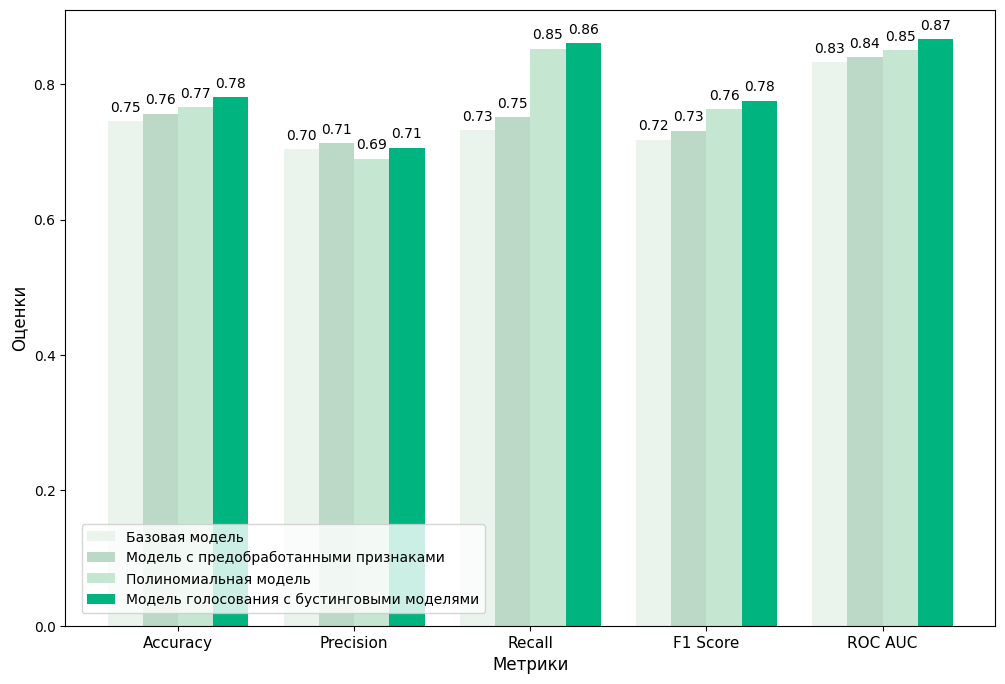

In [198]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
raw_values = [raw_accuracy, raw_precision, raw_recall, raw_f1, raw_roc_auc]
processed_values = [accuracy, precision, recall, f1, roc_auc]
polynomial_values = [accuracy_3, precision_3, recall_3, f1_3, roc_auc_3]
voting_values = [accuracy_vote3, precision_vote3, recall_vote3, f1_vote3, roc_auc_vote3]

x = np.arange(len(metrics))

width = 0.2


colors = sns.light_palette('seagreen', n_colors=5)


fig, ax = plt.subplots(figsize=(12, 8))


bars1 = ax.bar(x - 1.5 * width, raw_values, width, label='Базовая модель', color=colors[0])
bars2 = ax.bar(x - 0.5 * width, processed_values, width, label='Модель с предобработанными признаками', color=colors[1])
bars3 = ax.bar(x + 0.5 * width, polynomial_values, width, label='Полиномиальная модель', color='#c5e7d1')
bars4 = ax.bar(x + 1.5 * width, voting_values, width, label='Модель голосования c бустинговыми моделями', color='#00B47F')


ax.set_xlabel('Метрики', fontsize=12)
ax.set_ylabel('Оценки', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)


ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.01), frameon=True, fontsize=10)


for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10)


plt.savefig('compar.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)


plt.show()


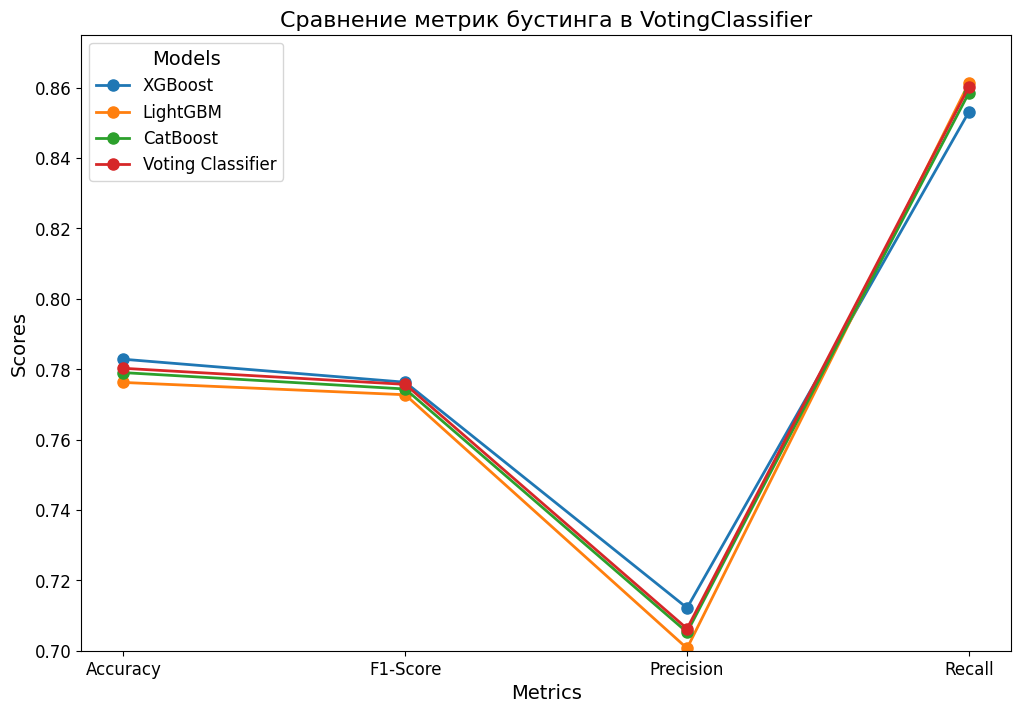

In [199]:
import matplotlib.pyplot as plt
import numpy as np

models = ['XGBoost', 'LightGBM', 'CatBoost', 'Voting Classifier']
accuracy = [accuracy_xgb3, accuracy_lgbm3, accuracy_catboost3, accuracy_vote3]
f1 = [f1_xgb3, f1_lgbm3, f1_catboost3, f1_vote3]
precision = [precision_xgb3, precision_lgbm3, precision_catboost3, precision_vote3]
recall = [recall_xgb3, recall_lgbm3, recall_catboost3, recall_vote3]


metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
metric_values = np.array([accuracy, f1, precision, recall])


plt.figure(figsize=(12, 8))  


for i, model in enumerate(models):
    plt.plot(metrics, metric_values[:, i], label=model, linestyle='-', marker='o', linewidth=2, markersize=8)


plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Сравнение метрик бустинга в VotingClassifier', fontsize=16)


plt.ylim(0.7, 0.875)


plt.legend(title='Models', fontsize=12, title_fontsize=14)


plt.xticks(fontsize=12)

plt.yticks(fontsize=12)

plt.savefig('boost.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()

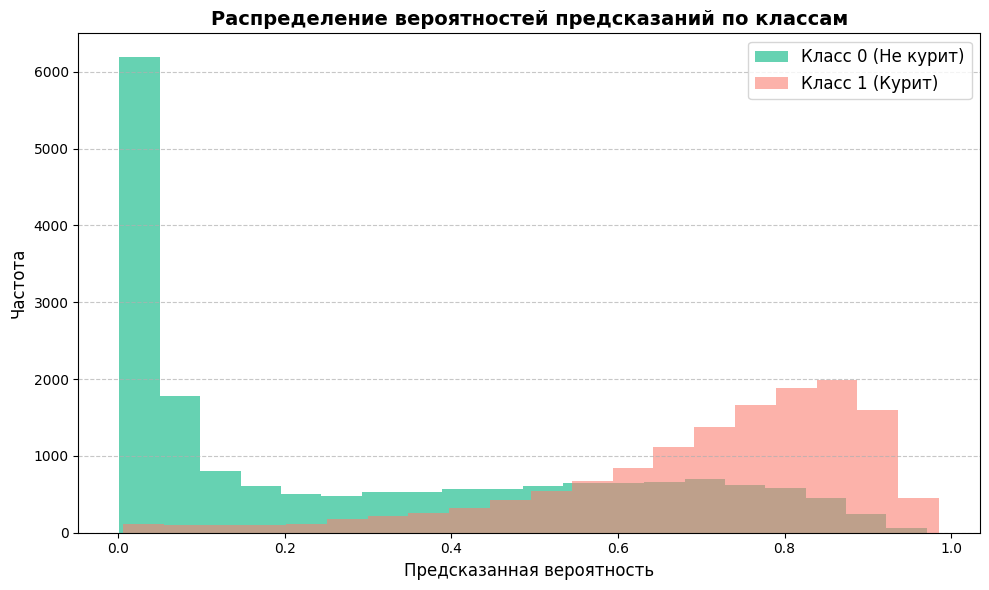

In [200]:
plt.figure(figsize=(10, 6))

plt.hist(y_pred_proba_vote3[y_test == 0], bins=20, alpha=0.6, label="Класс 0 (Не курит)", color="#00B47F")
plt.hist(y_pred_proba_vote3[y_test == 1], bins=20, alpha=0.6, label="Класс 1 (Курит)", color="salmon")

plt.title("Распределение вероятностей предсказаний по классам", fontsize=14, fontweight="bold")
plt.xlabel("Предсказанная вероятность", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig('dictrib.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()

In [206]:
import joblib

MODEL_FILE = "voting_model3.pkl"

joblib.dump(voting_model3, MODEL_FILE)

print(f"Model saved to {MODEL_FILE}")

Model saved to voting_model3.pkl
